In [2]:
import warnings
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
# sns.set(rc={'figure.figsize':(11.7,8.27)})
rcParams['figure.figsize'] = 16,9
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-dark')

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, mean_absolute_error
from pandas.plotting import scatter_matrix
# from roc import plot_roc

In [3]:
# Create your connection.
cnx = sqlite3.connect('data/cities.db')

In [4]:
# Create pandas data frame
df = pd.read_sql_query("SELECT * FROM vehicles", cnx)

In [5]:
df.shape

(52171, 20)

In [6]:
df.size

1043420

In [7]:
df.head()

,url,city,price,year,manufacturer,make,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,lat,long
0,https://slo.craigslist.org/ctd/d/nipomo-2010-m...,slo,NaN,2010.0,mercury,mariner,None,None,gas,92155.0,clean,automatic,4M2CN8B73AKJ23489,fwd,None,SUV,blue,https://images.craigslist.org/00y0y_2DeHnxeUa7...,35.024220,-120.472180
1,https://slo.craigslist.org/cto/d/santa-barbara...,slo,NaN,2005.0,volvo,v70xc wagon,excellent,5 cylinders,gas,185000.0,clean,automatic,None,4wd,mid-size,wagon,blue,https://images.craigslist.org/00T0T_9qKOzTMmcX...,34.419700,-119.707800
2,https://slo.craigslist.org/ctd/d/san-luis-obis...,slo,NaN,2008.0,mazda,mazda3,None,None,gas,109528.0,clean,automatic,JM1BK32G781139577,None,None,sedan,silver,https://images.craigslist.org/00Q0Q_c5yeYN8gwA...,35.267013,-120.670023
3,https://slo.craigslist.org/ctd/d/templeton-200...,slo,NaN,2007.0,chevrolet,suburban,good,8 cylinders,gas,103000.0,clean,automatic,None,rwd,full-size,SUV,brown,https://images.craigslist.org/00S0S_cErMrUgwe1...,35.512448,-120.699771
4,https://slo.craigslist.org/ctd/d/templeton-200...,slo,NaN,2005.0,chevrolet,trailblazer,good,6 cylinders,gas,90000.0,clean,automatic,None,rwd,mid-size,SUV,silver,https://images.craigslist.org/00y0y_h7JL9b2AEy...,35.512566,-120.699729


In [8]:
df.price.isna().mean()

0.032930171934599684

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52171 entries, 0 to 52170
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           52171 non-null  object 
 1   city          52171 non-null  object 
 2   price         50453 non-null  float64
 3   year          52006 non-null  float64
 4   manufacturer  49689 non-null  object 
 5   make          52162 non-null  object 
 6   condition     33415 non-null  object 
 7   cylinders     31424 non-null  object 
 8   fuel          52048 non-null  object 
 9   odometer      50749 non-null  float64
 10  title_status  50844 non-null  object 
 11  transmission  51914 non-null  object 
 12  VIN           33839 non-null  object 
 13  drive         37009 non-null  object 
 14  size          15139 non-null  object 
 15  type          42740 non-null  object 
 16  paint_color   35773 non-null  object 
 17  image_url     52162 non-null  object 
 18  lat           52119 non-nu

In [10]:
df.condition.unique()

array([None, 'excellent', 'good', 'salvage', 'like new', 'fair', 'new'],
      dtype=object)

In [11]:
df.columns

Index(['url', 'city', 'price', 'year', 'manufacturer', 'make', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'image_url', 'lat', 'long'],
      dtype='object')

In [12]:
features = [
    'price',
    'city',
    'year',
    'manufacturer',
    'condition',
    'cylinders',
    'fuel',
    'odometer',
    'title_status',
    'transmission',
    'size',
    'paint_color',
]

df1 = df[features]

In [13]:
# df1.dropna(axis=0, inplace=True)

In [14]:
# df1.shape #(9606, 11)

In [15]:
df1.shape

(52171, 12)

In [16]:
df1.isna().sum()

price            1718
city                0
year              165
manufacturer     2482
condition       18756
cylinders       20747
fuel              123
odometer         1422
title_status     1327
transmission      257
size            37032
paint_color     16398
dtype: int64

In [17]:
features = [
    'price',
    'city',
    'year',
    'manufacturer',
    'fuel',
    'odometer',
    'title_status',
    'transmission',
    'condition'
]
cars = df1[features]

In [18]:
# normalizing values
# scaler = StandardScaler()
# scaled_price = scaler.fit_transform(cars.price)
cars.price = cars.price[~((cars.price - cars.price.mean()).abs() > 0.5 * cars.price.std())]
cars.odometer = cars.odometer[~((cars.odometer-cars.odometer.mean()).abs() > 5 * cars.odometer.std())]
# scaled_odometer = scaler.fit_transform(cars.odometer)

In [19]:
# cars.price[price == 0].count()

In [20]:
cars.dropna(axis=0, inplace=True)

In [21]:
cars.shape

(28634, 9)

cars.isna().sum()

In [22]:
cars.columns

Index(['price', 'city', 'year', 'manufacturer', 'fuel', 'odometer',
       'title_status', 'transmission', 'condition'],
      dtype='object')

In [23]:
cars.describe(include=[np.object, pd.Categorical]).T

,count,unique,top,freq
city,28634,30,ventura,1966
manufacturer,28634,39,ford,3936
fuel,28634,5,gas,23567
title_status,28634,6,clean,27616
transmission,28634,3,automatic,21820
condition,28634,6,good,12889


In [24]:
# 39 unique manufacturers, 30 cities

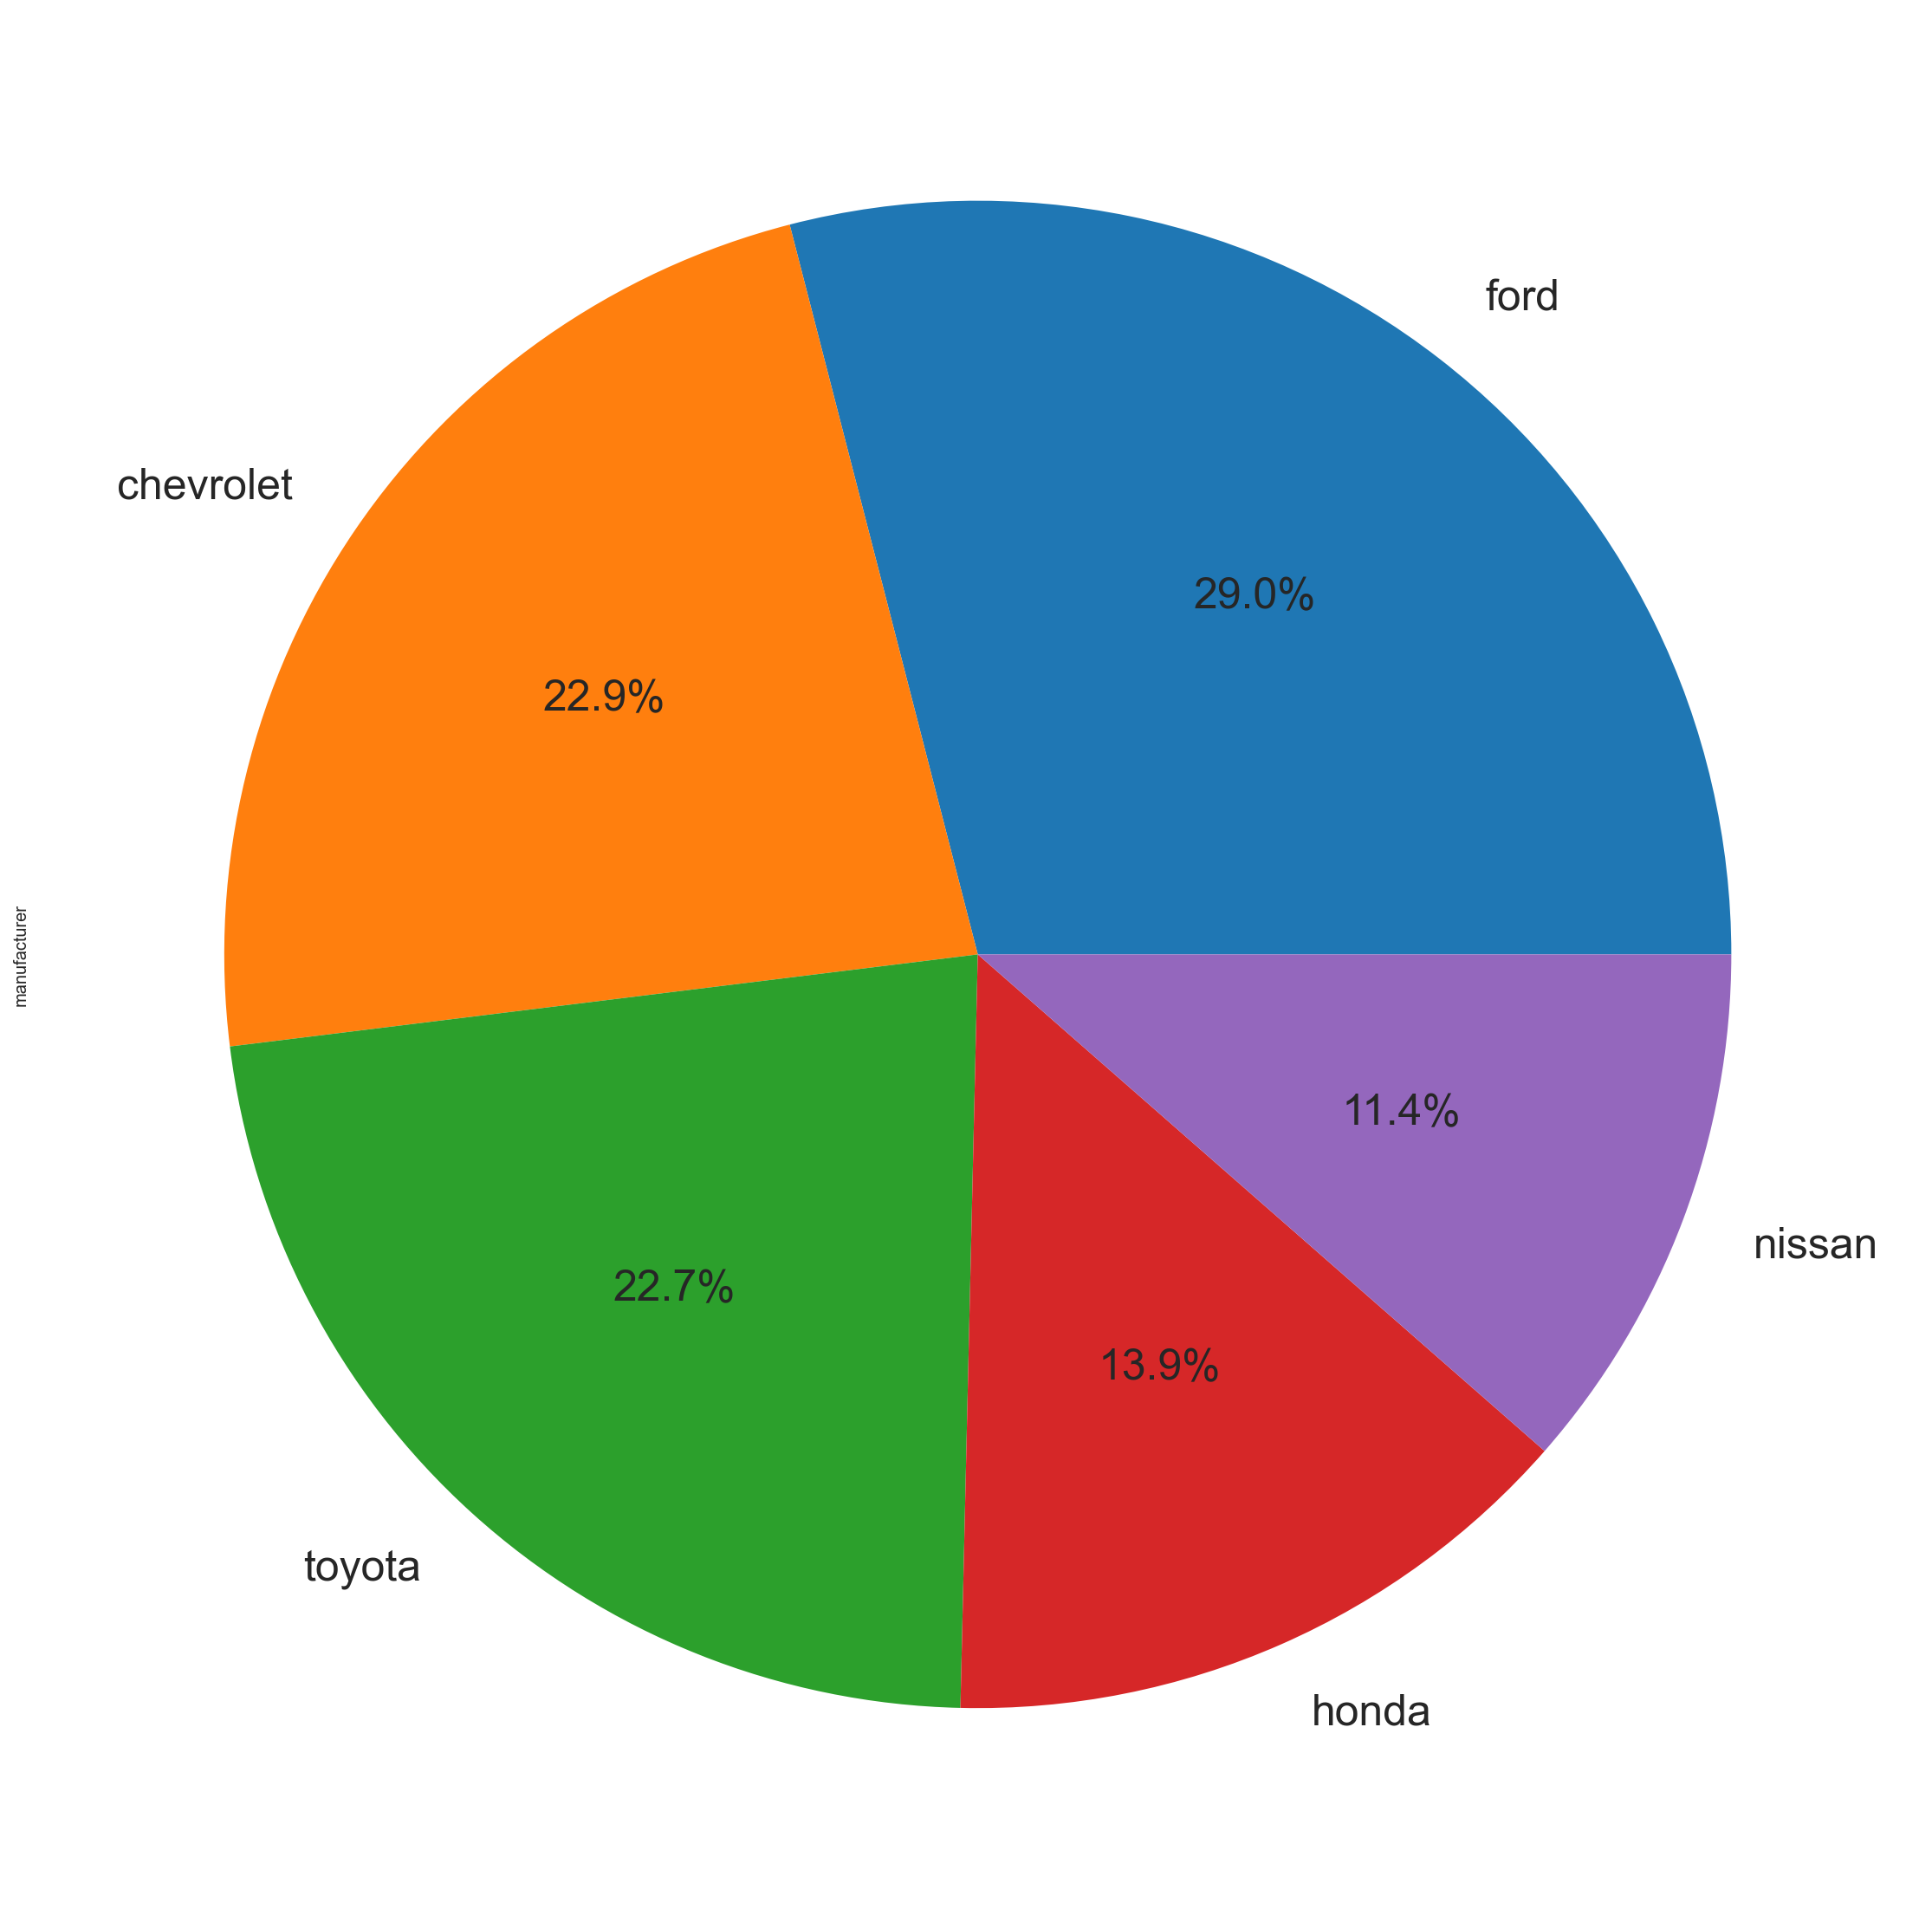

In [25]:
# The distribution of the top 5 car manufacturers.
cars.manufacturer.value_counts().head(5).plot(kind='pie', subplots=True, fontsize = 25, figsize=(20,20), autopct='%1.1f%%')
plt.savefig('manu_distrib_pie.png', bbox_inches='tight')

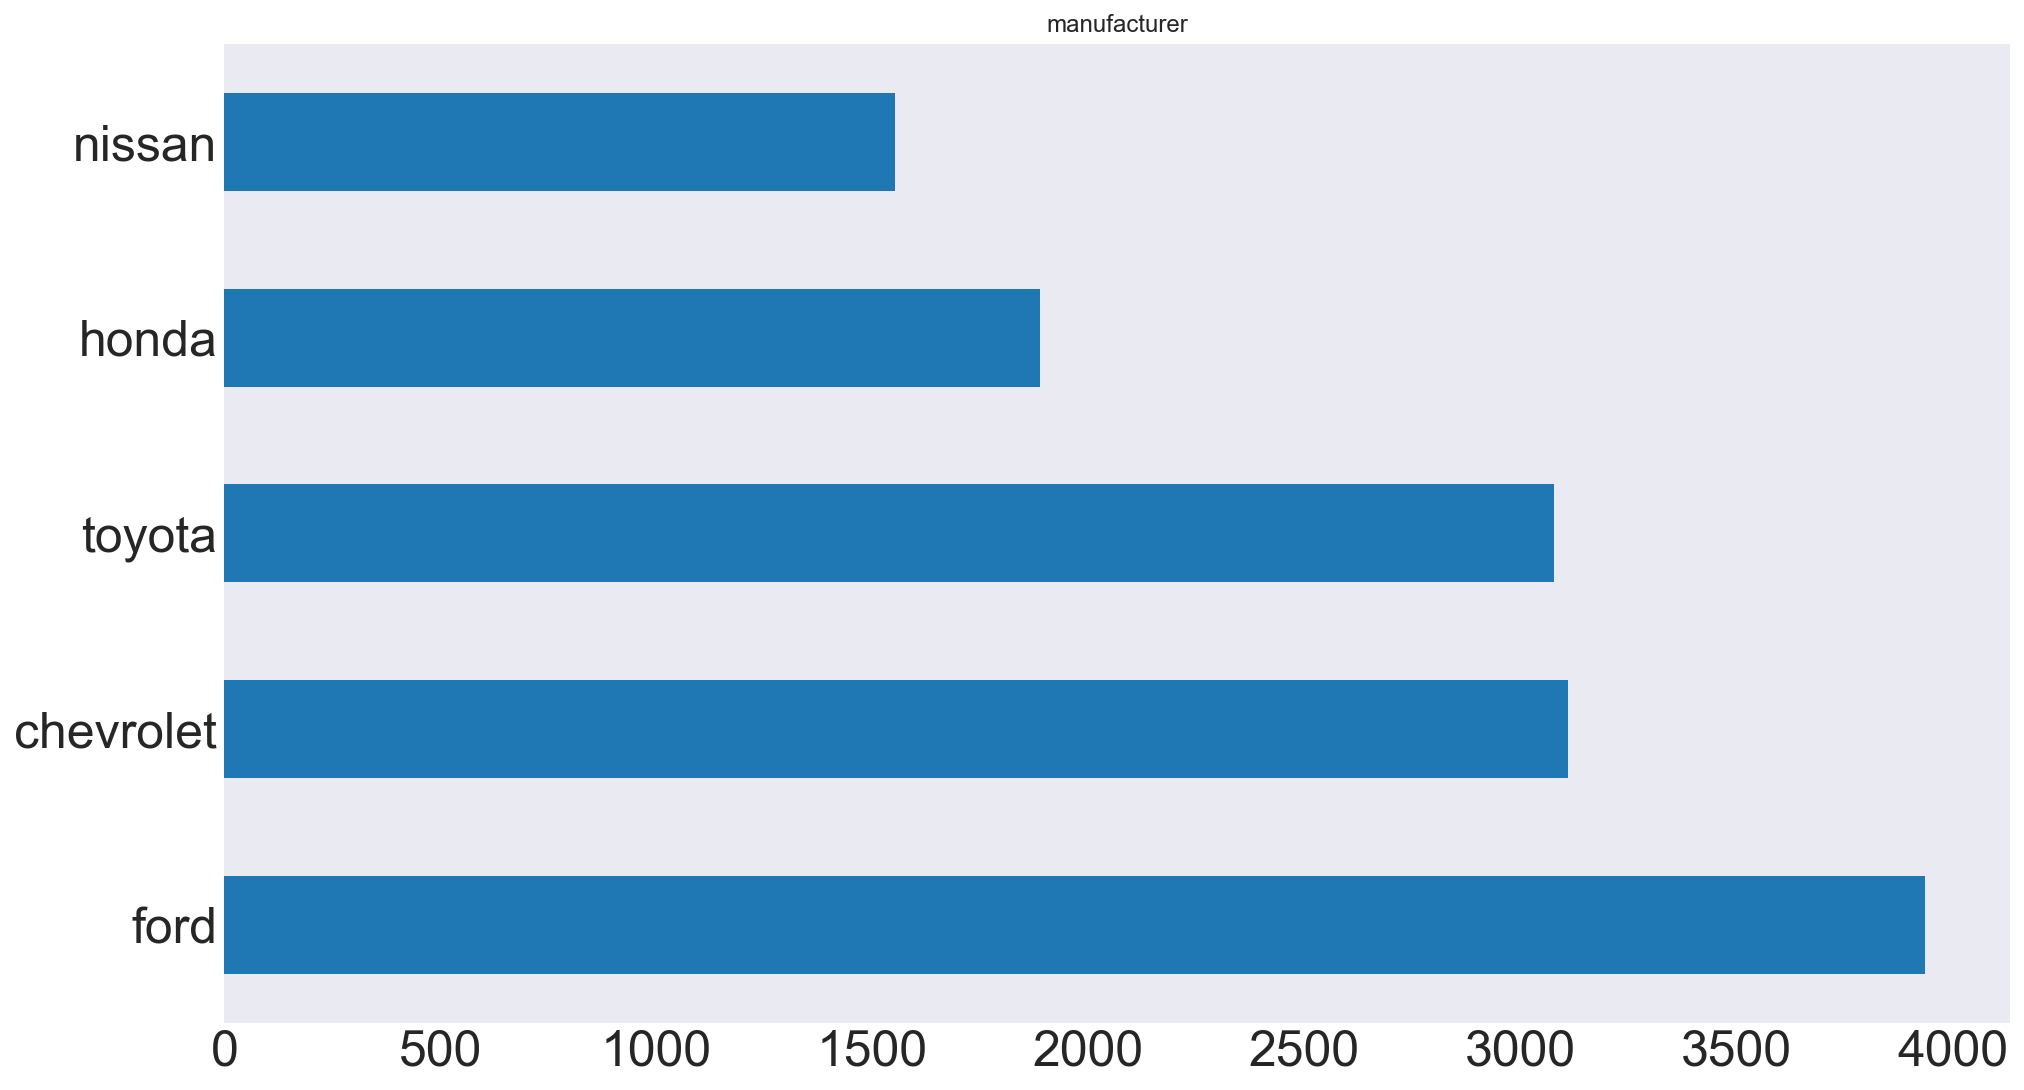

In [26]:
cars.manufacturer.value_counts().head(5).plot(kind='barh', subplots=True, fontsize = 25, figsize = (16,9))
plt.savefig('manu_distrib_plot.png', bbox_inches='tight')

From the graph we can see the distribution of the top 5 manufacturing companies within the dataset.If you prefer Ford vehicles, Ford has the highest number of vehicles available for purchase, meaning you have a large number of vehicles to choose from. They are followed by chevrolet and toyota. Nissan has the lowest number of cars available for sale, so persons who prefer this brand may have a lower chance of finding their ideal vehicle.

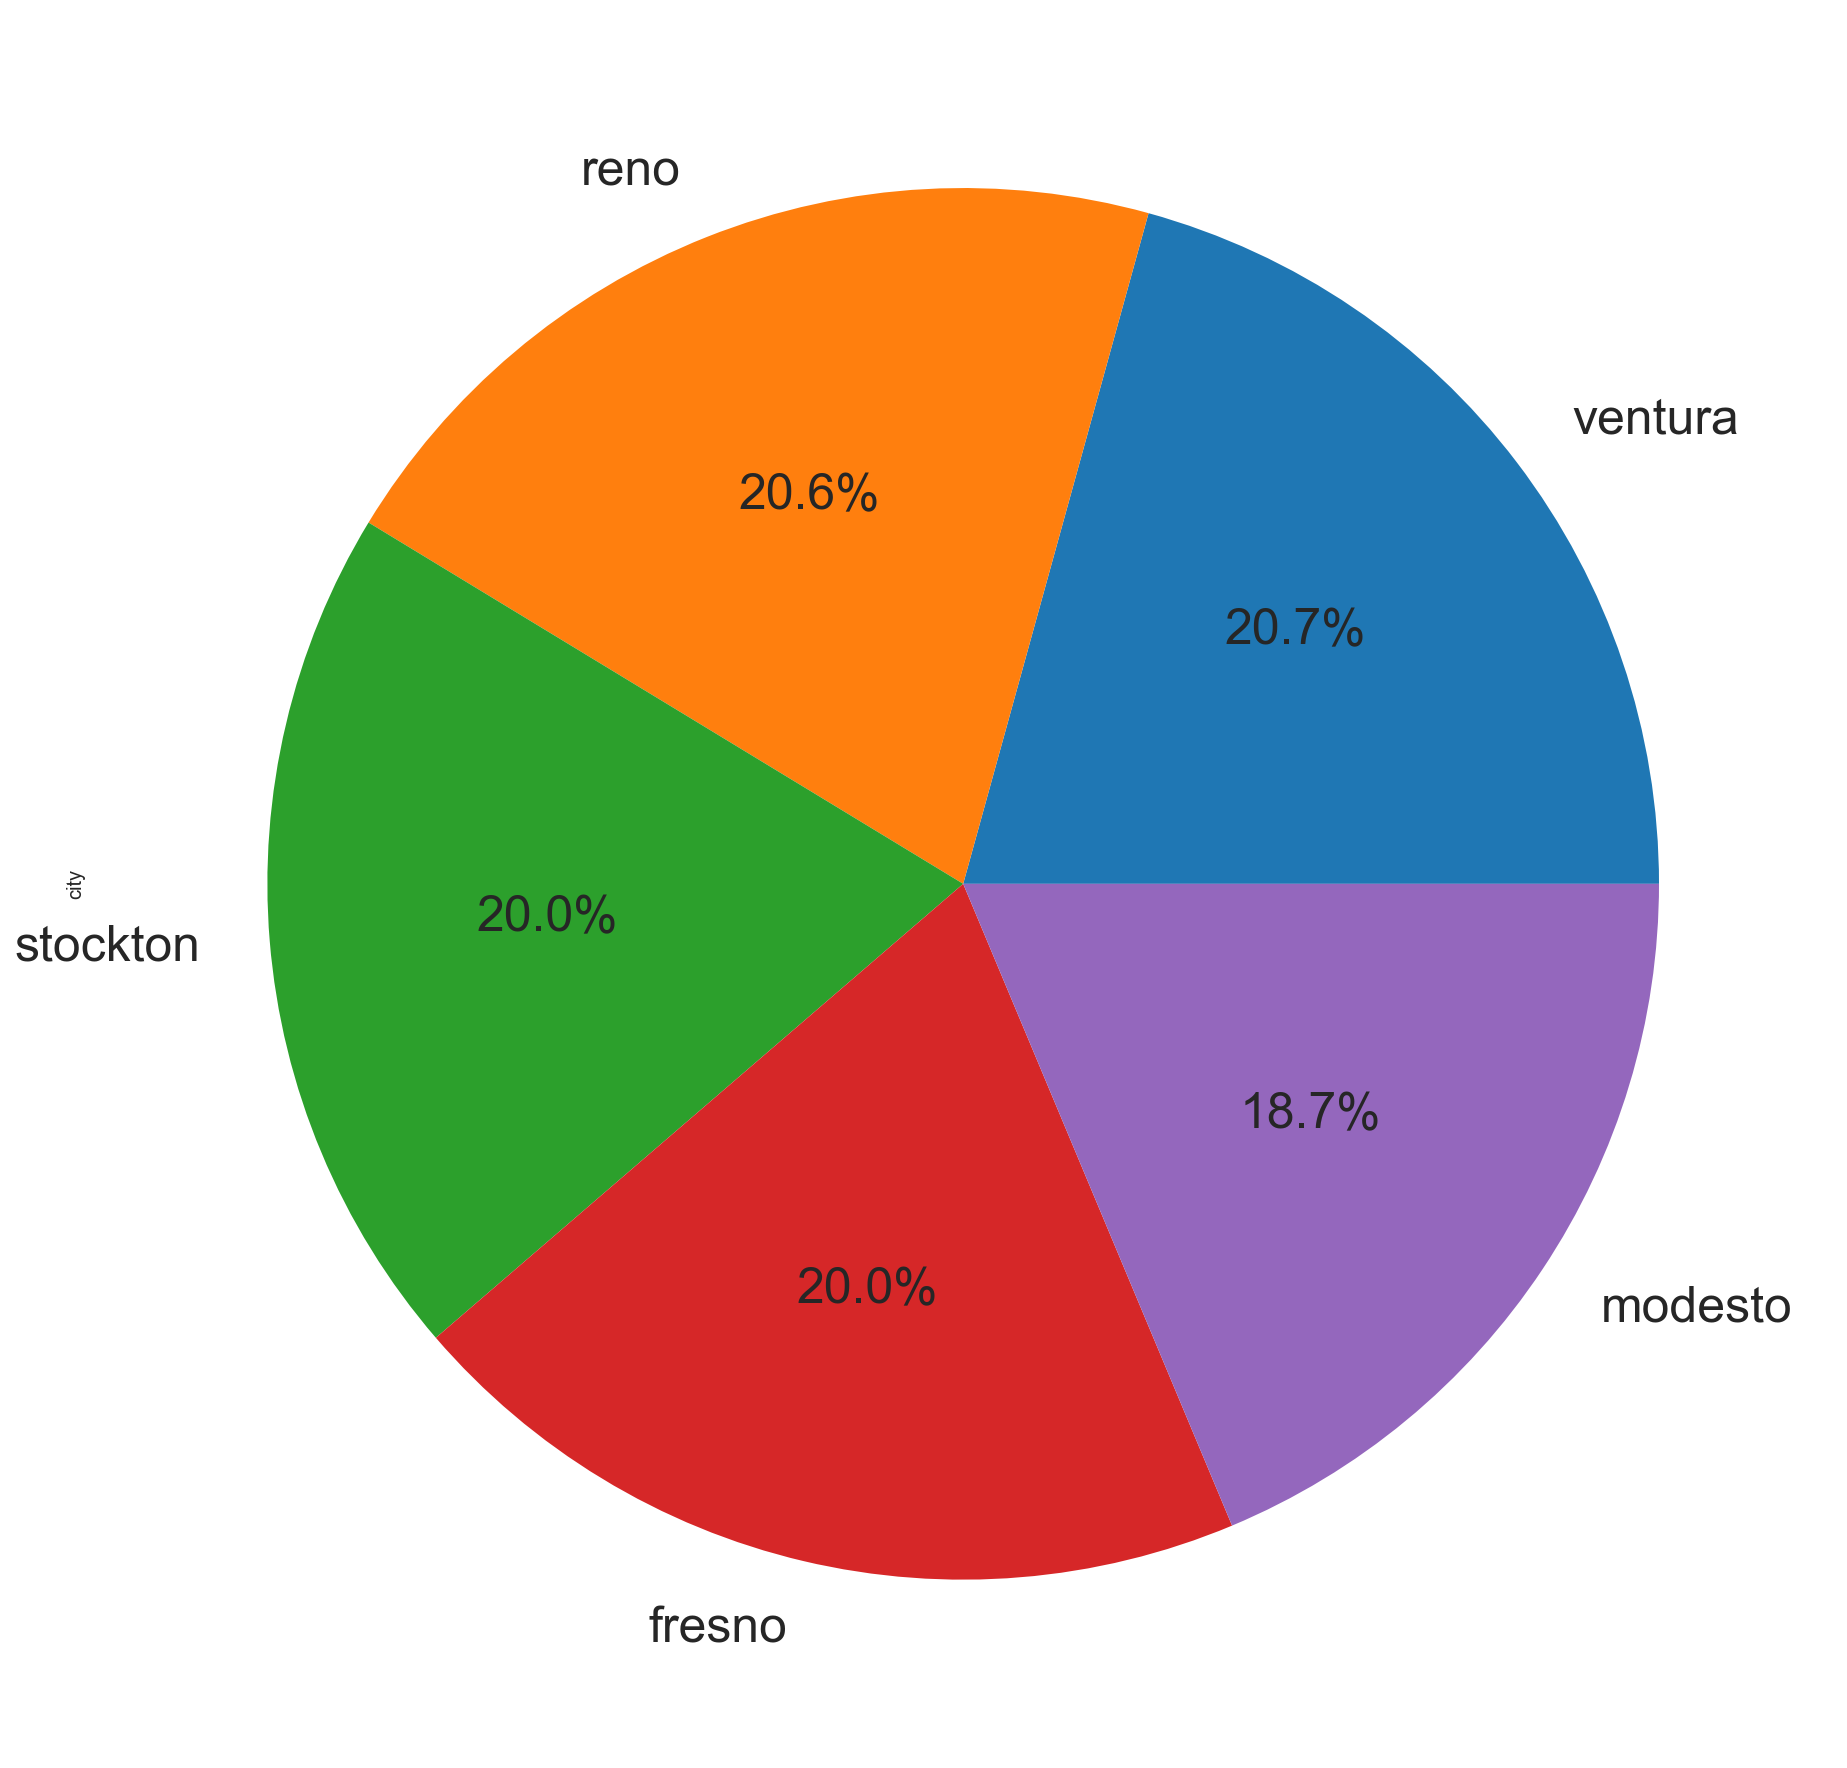

In [27]:
# The distribution of the top 5 cities to buy a car from.
cars.city.value_counts().head(5).plot(kind='pie', subplots=True, figsize=(16,16) ,fontsize=25, autopct='%1.1f%%')
plt.savefig('city_distrib_pie.png', bbox_inches='tight')

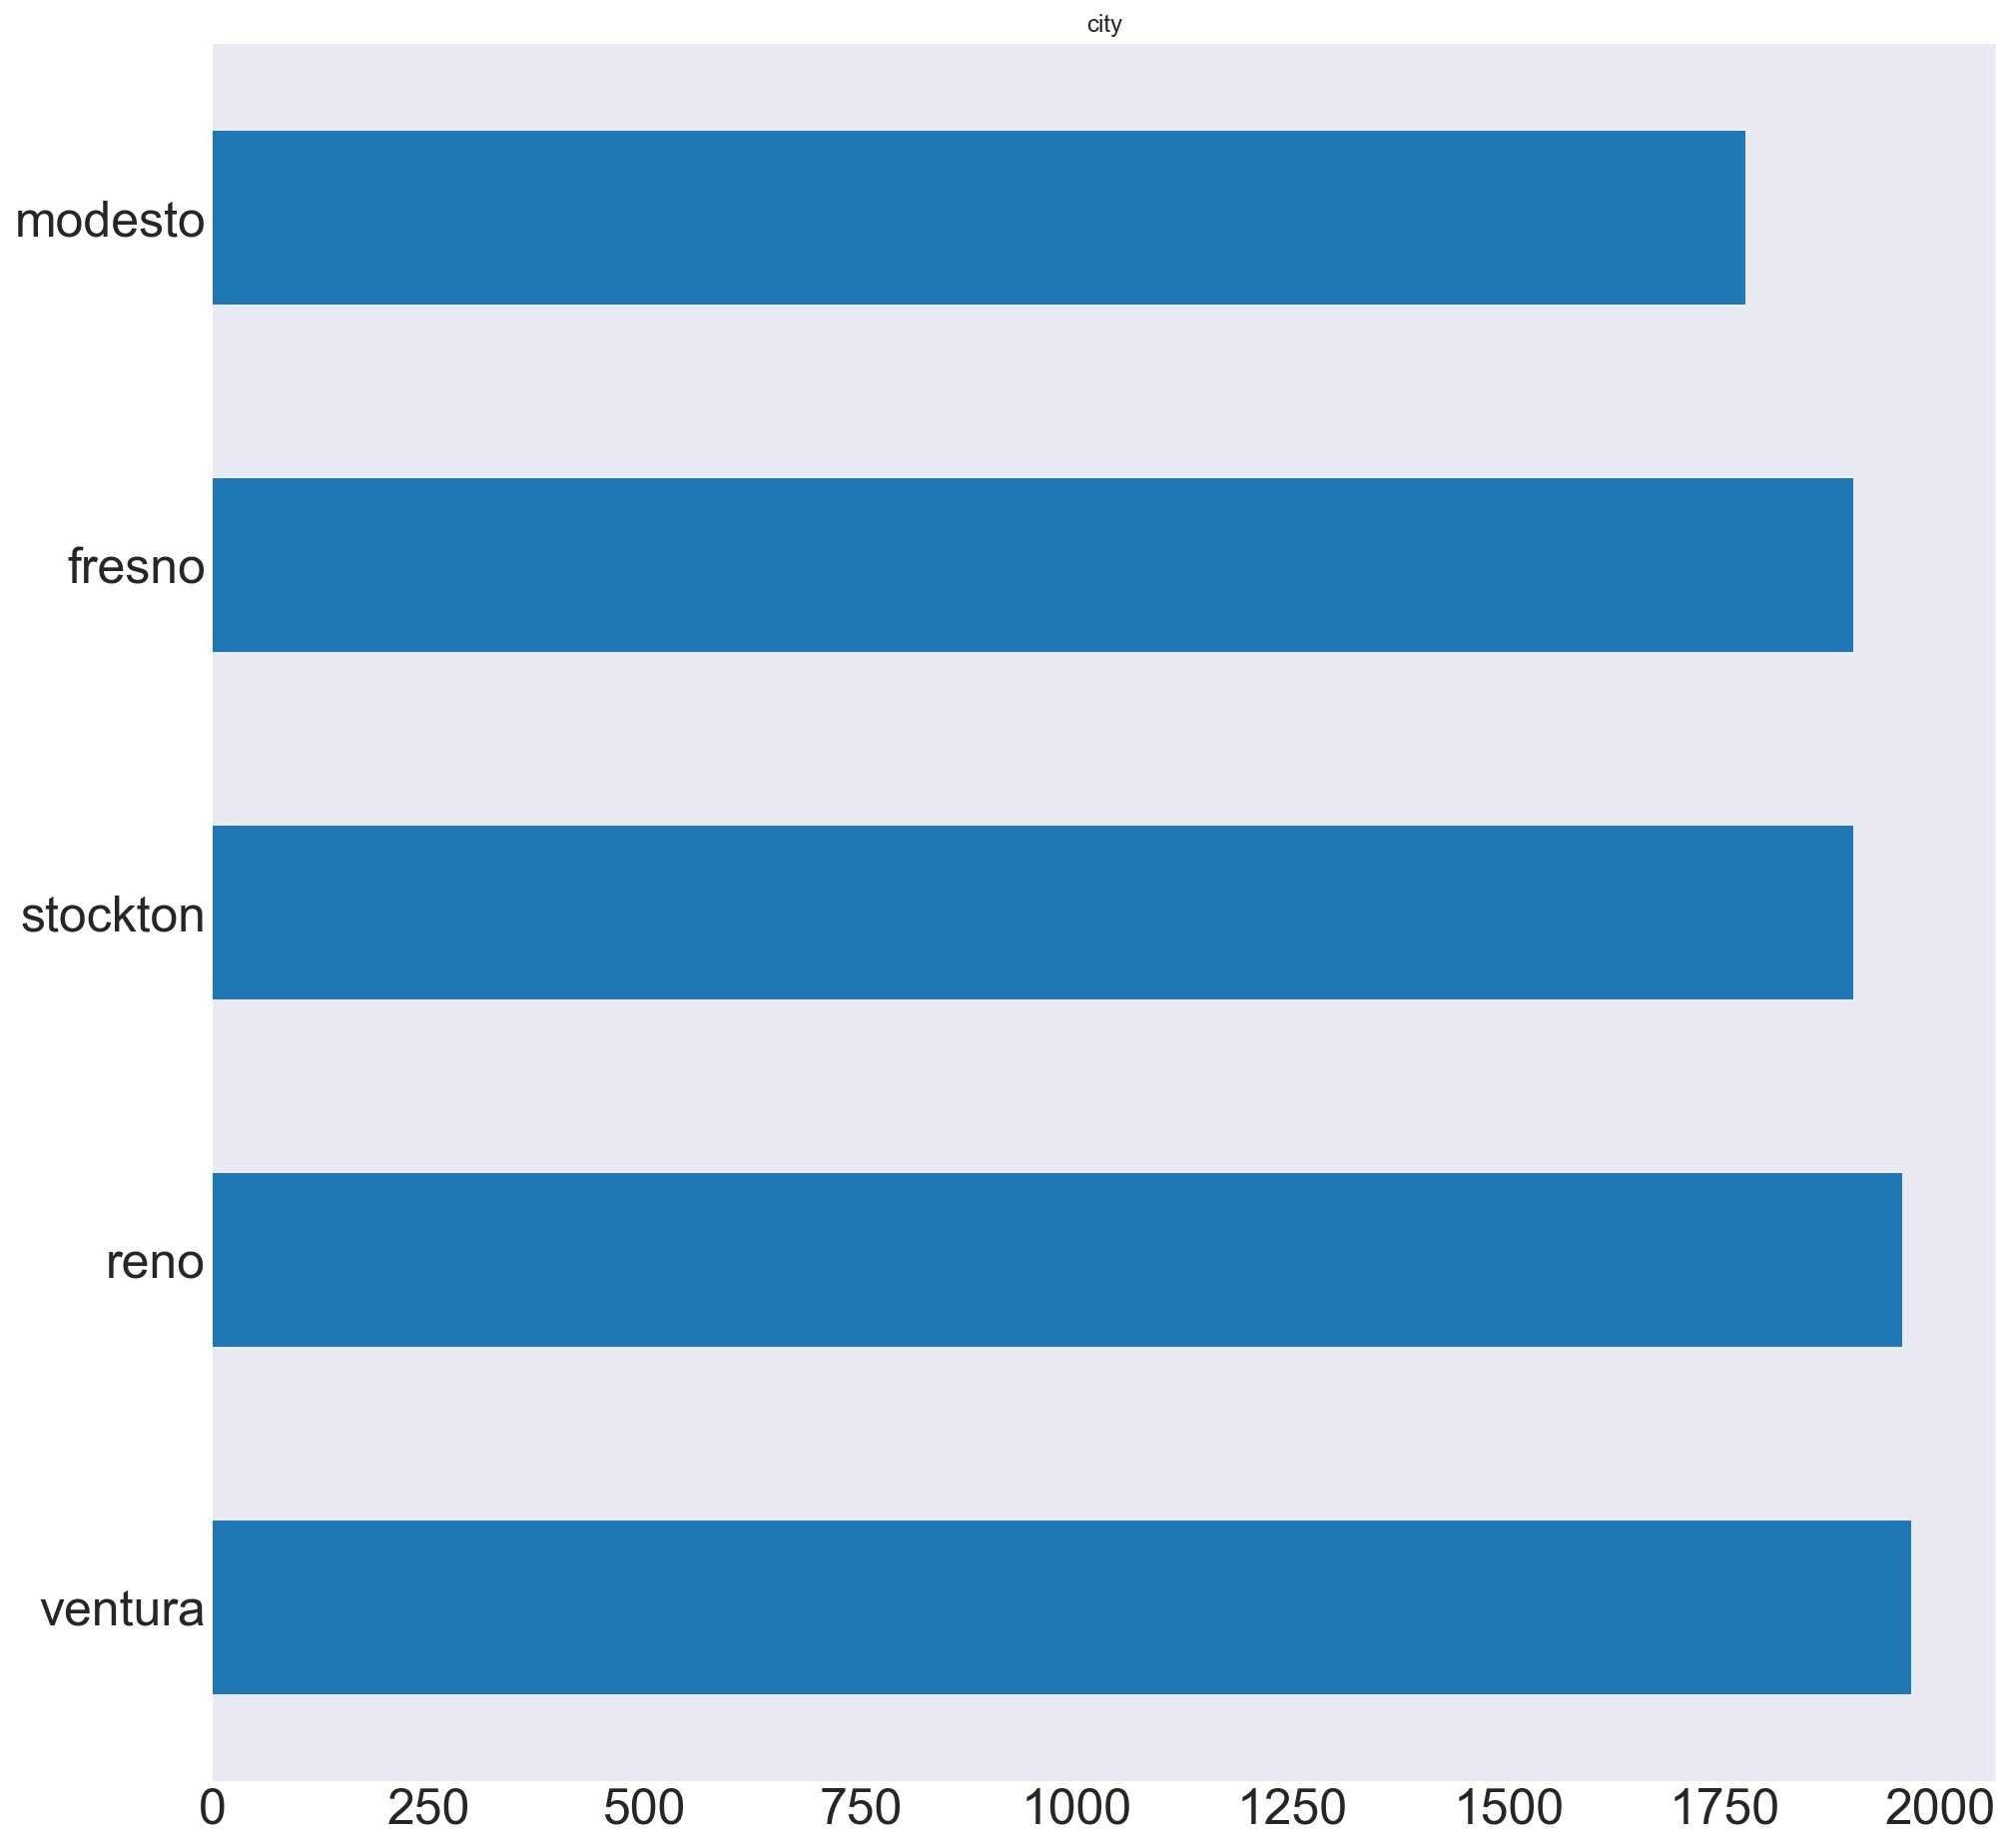

In [28]:
cars.city.value_counts().head(5).plot(kind='barh', subplots=True, figsize=(16,16), fontsize=25)
plt.savefig('city_distrib_plot.png', bbox_inches='tight')

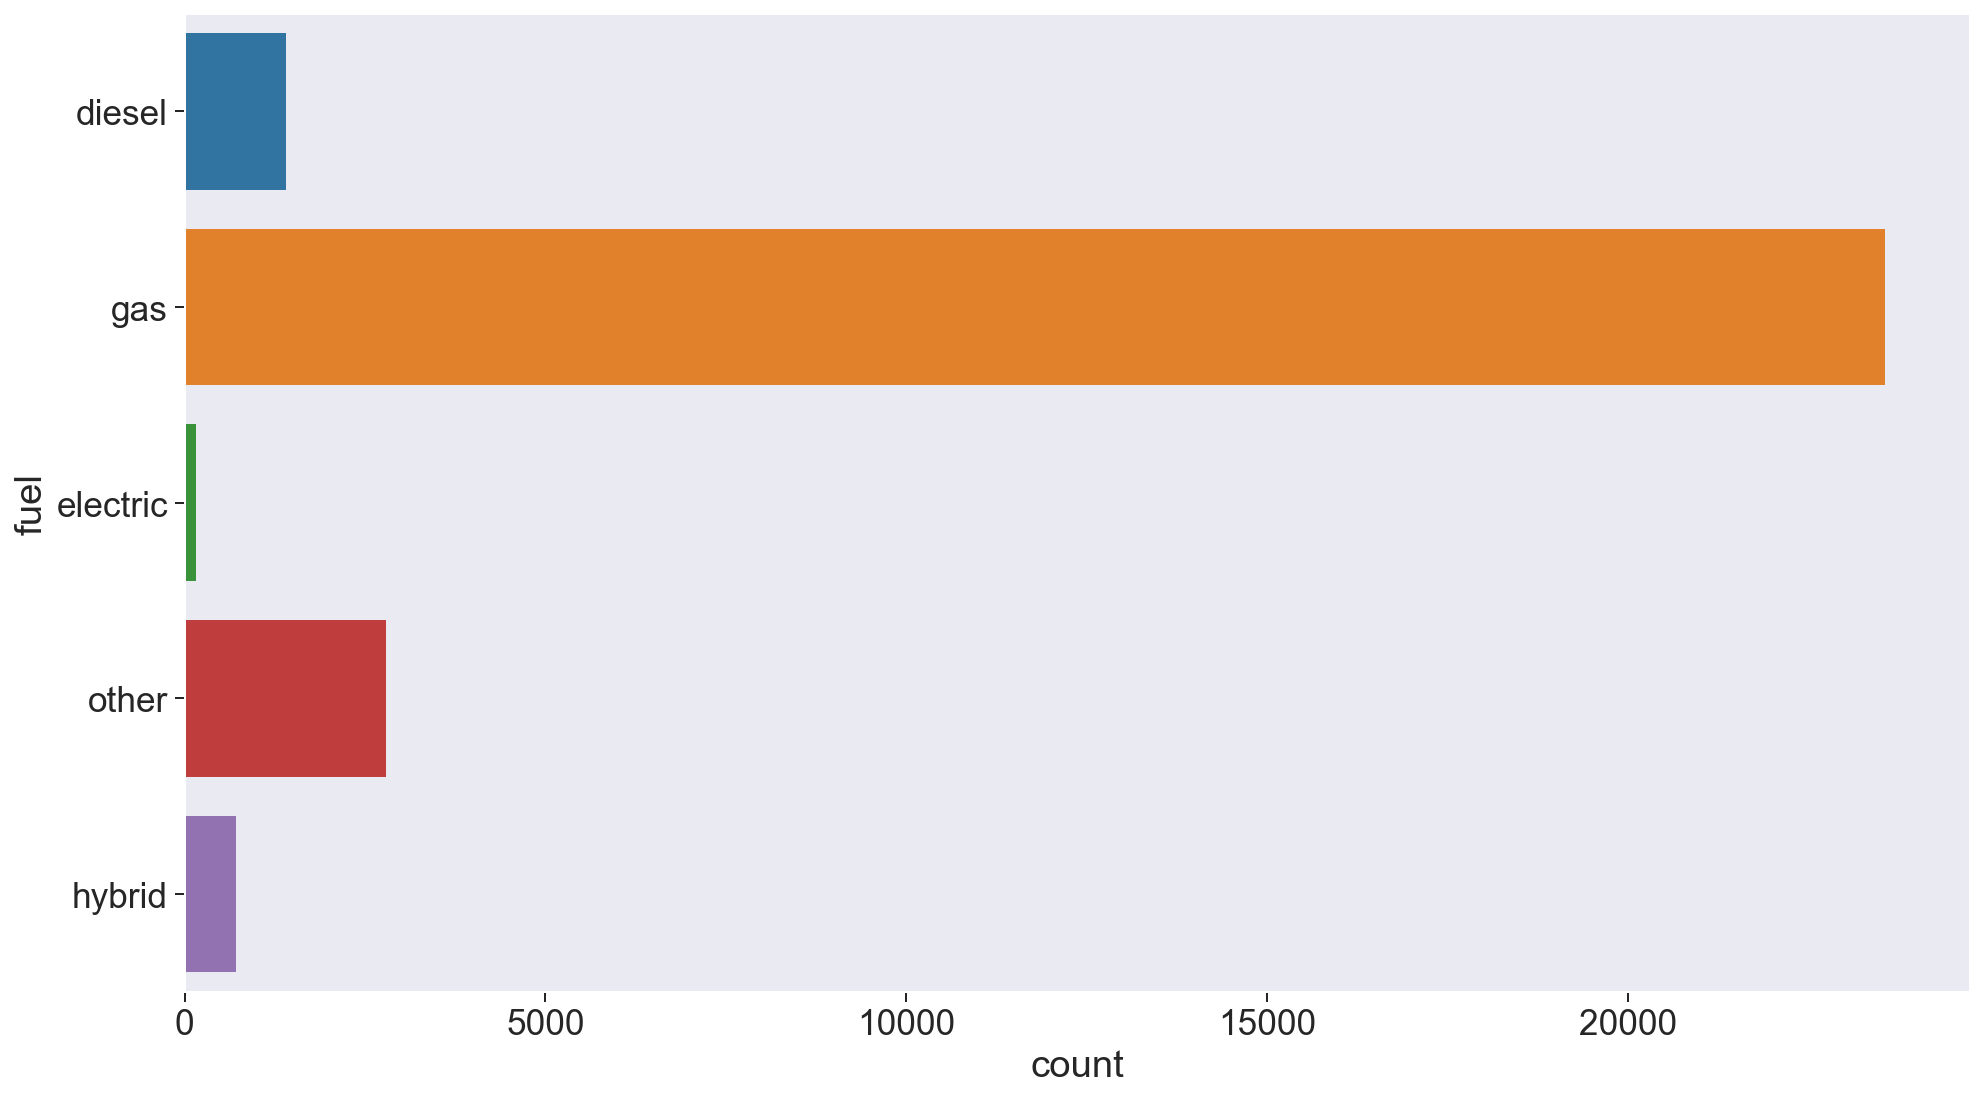

In [29]:
plt.figure(figsize=(16,9))
sns.set_context("paper", font_scale=2)
sns_countplot = sns.countplot(y='fuel', data=cars)
fig = sns_countplot.get_figure()
fig.savefig("output.png")

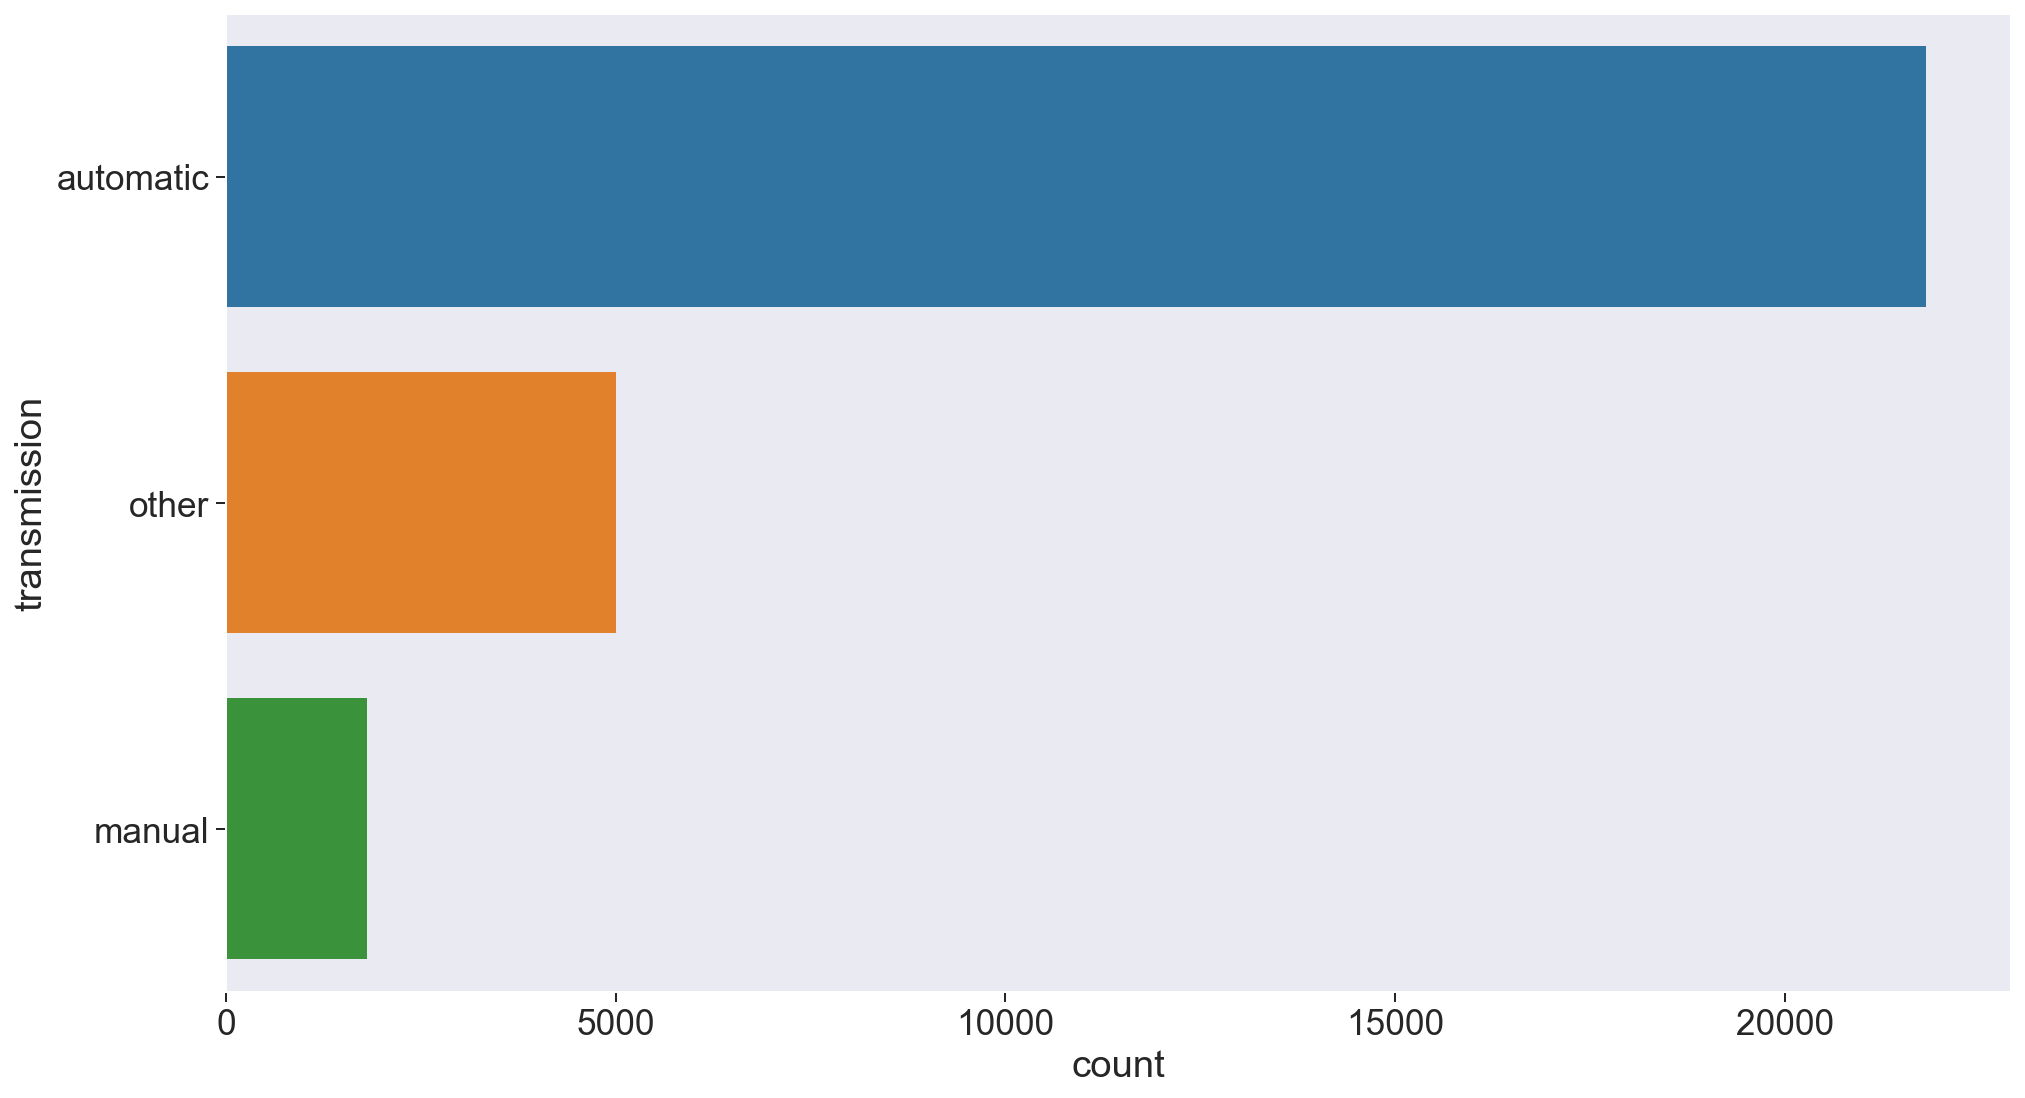

In [30]:
plt.figure(figsize=(16,9))
sns.set_context("paper", font_scale=2)
sns.countplot(y='transmission', data=cars)
plt.savefig('fuel.png', bbox_inches='tight')

## Find the best offer available using 5 features

* PRICE

* MANUFACTURER

* CITY

* TRANSMISSION

* YEAR


In [31]:
avg_price = cars['price']
avg_price.mean()

16483.809317594467

In [32]:
price = cars['price']
test_manufacturer = cars['manufacturer']
city = cars['city']
transmission = cars['transmission']
year = cars['year']
condition = cars['condition']

In [33]:
price.value_counts()

0.0        1187
6500.0      237
17990.0     236
14990.0     222
12990.0     220
           ... 
4290.0        1
5280.0        1
11785.0       1
1420.0        1
9888.0        1
Name: price, Length: 2244, dtype: int64

In [34]:
test_manufacturer.value_counts()
# len(test_manufacturer.unique())

ford               3936
chevrolet          3111
toyota             3077
honda              1888
nissan             1553
bmw                1297
mercedes-benz      1215
hyundai             930
lexus               914
volkswagen          911
dodge               868
jeep                843
gmc                 825
ram                 810
subaru              659
kia                 643
audi                642
mazda               490
acura               476
chrysler            446
infiniti            436
cadillac            412
mini                362
lincoln             274
volvo               266
jaguar              236
buick               223
mitsubishi          219
rover               188
fiat                114
pontiac             113
alfa-romeo           92
saturn               63
mercury              58
ferrari              19
datsun               14
harley-davidson       5
land rover            3
aston-martin          3
Name: manufacturer, dtype: int64

In [35]:
city.value_counts()
len(city.unique())

30

In [36]:
transmission.value_counts()

automatic    21820
other         5005
manual        1809
Name: transmission, dtype: int64

In [37]:
year.value_counts()

2014.0    2303
2015.0    2155
2017.0    2110
2013.0    2092
2018.0    2071
          ... 
1935.0       1
1942.0       1
1934.0       1
2022.0       1
1938.0       1
Name: year, Length: 97, dtype: int64

In [38]:
condition.value_counts()

good         12889
excellent    12558
like new      2446
fair           576
new             86
salvage         79
Name: condition, dtype: int64

In [39]:
price_count = price.value_counts()
man_count = test_manufacturer.value_counts()
year_count = year.value_counts()
city_count = city.value_counts()
transmission_count = transmission.value_counts()
condition_count = condition.value_counts()

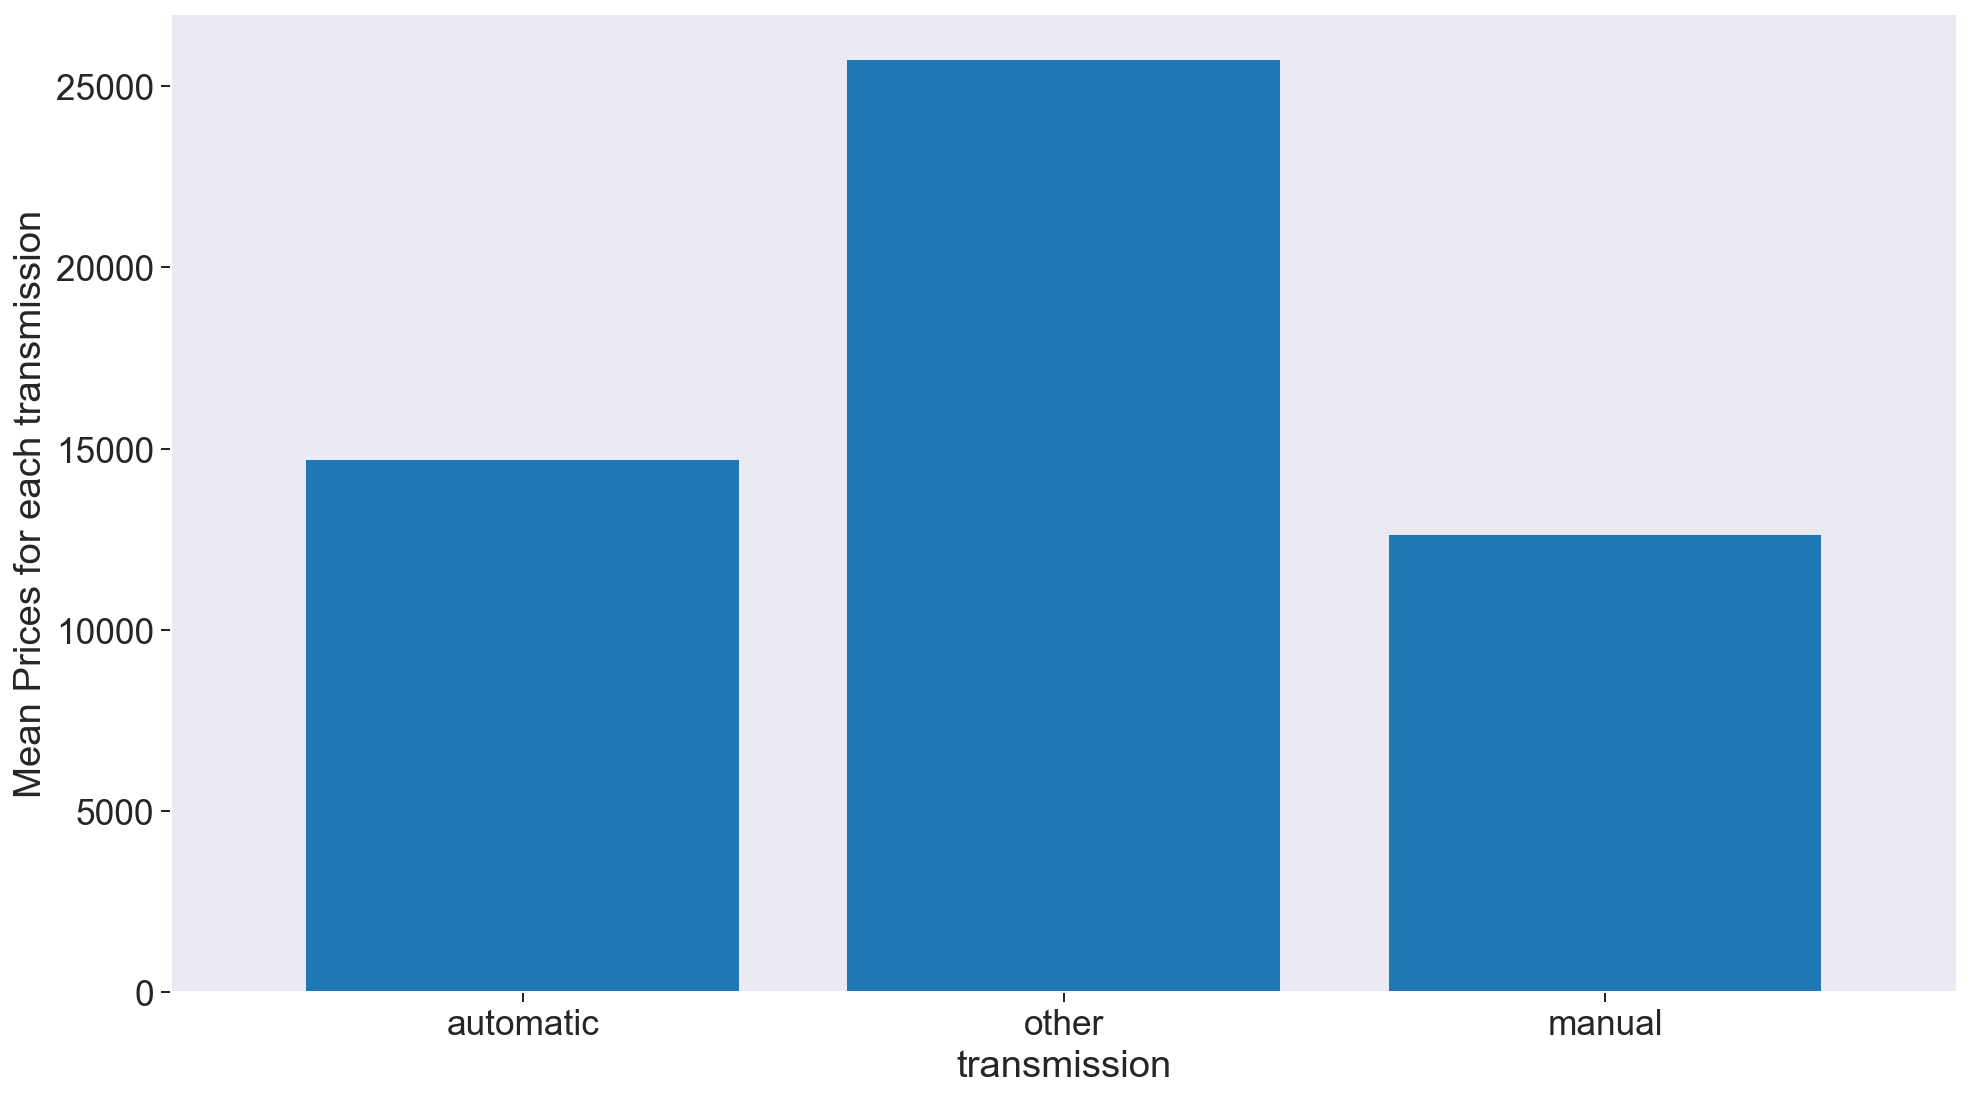

In [40]:
avg = cars.groupby('transmission', sort=False)['price'].mean()
bx = avg.plot(kind='bar', rot=0, figsize=(16, 9), width=.8)
bx.set_ylabel('Mean Prices for each transmission')
plt.savefig('priceVstrans.png', bbox_inches='tight')

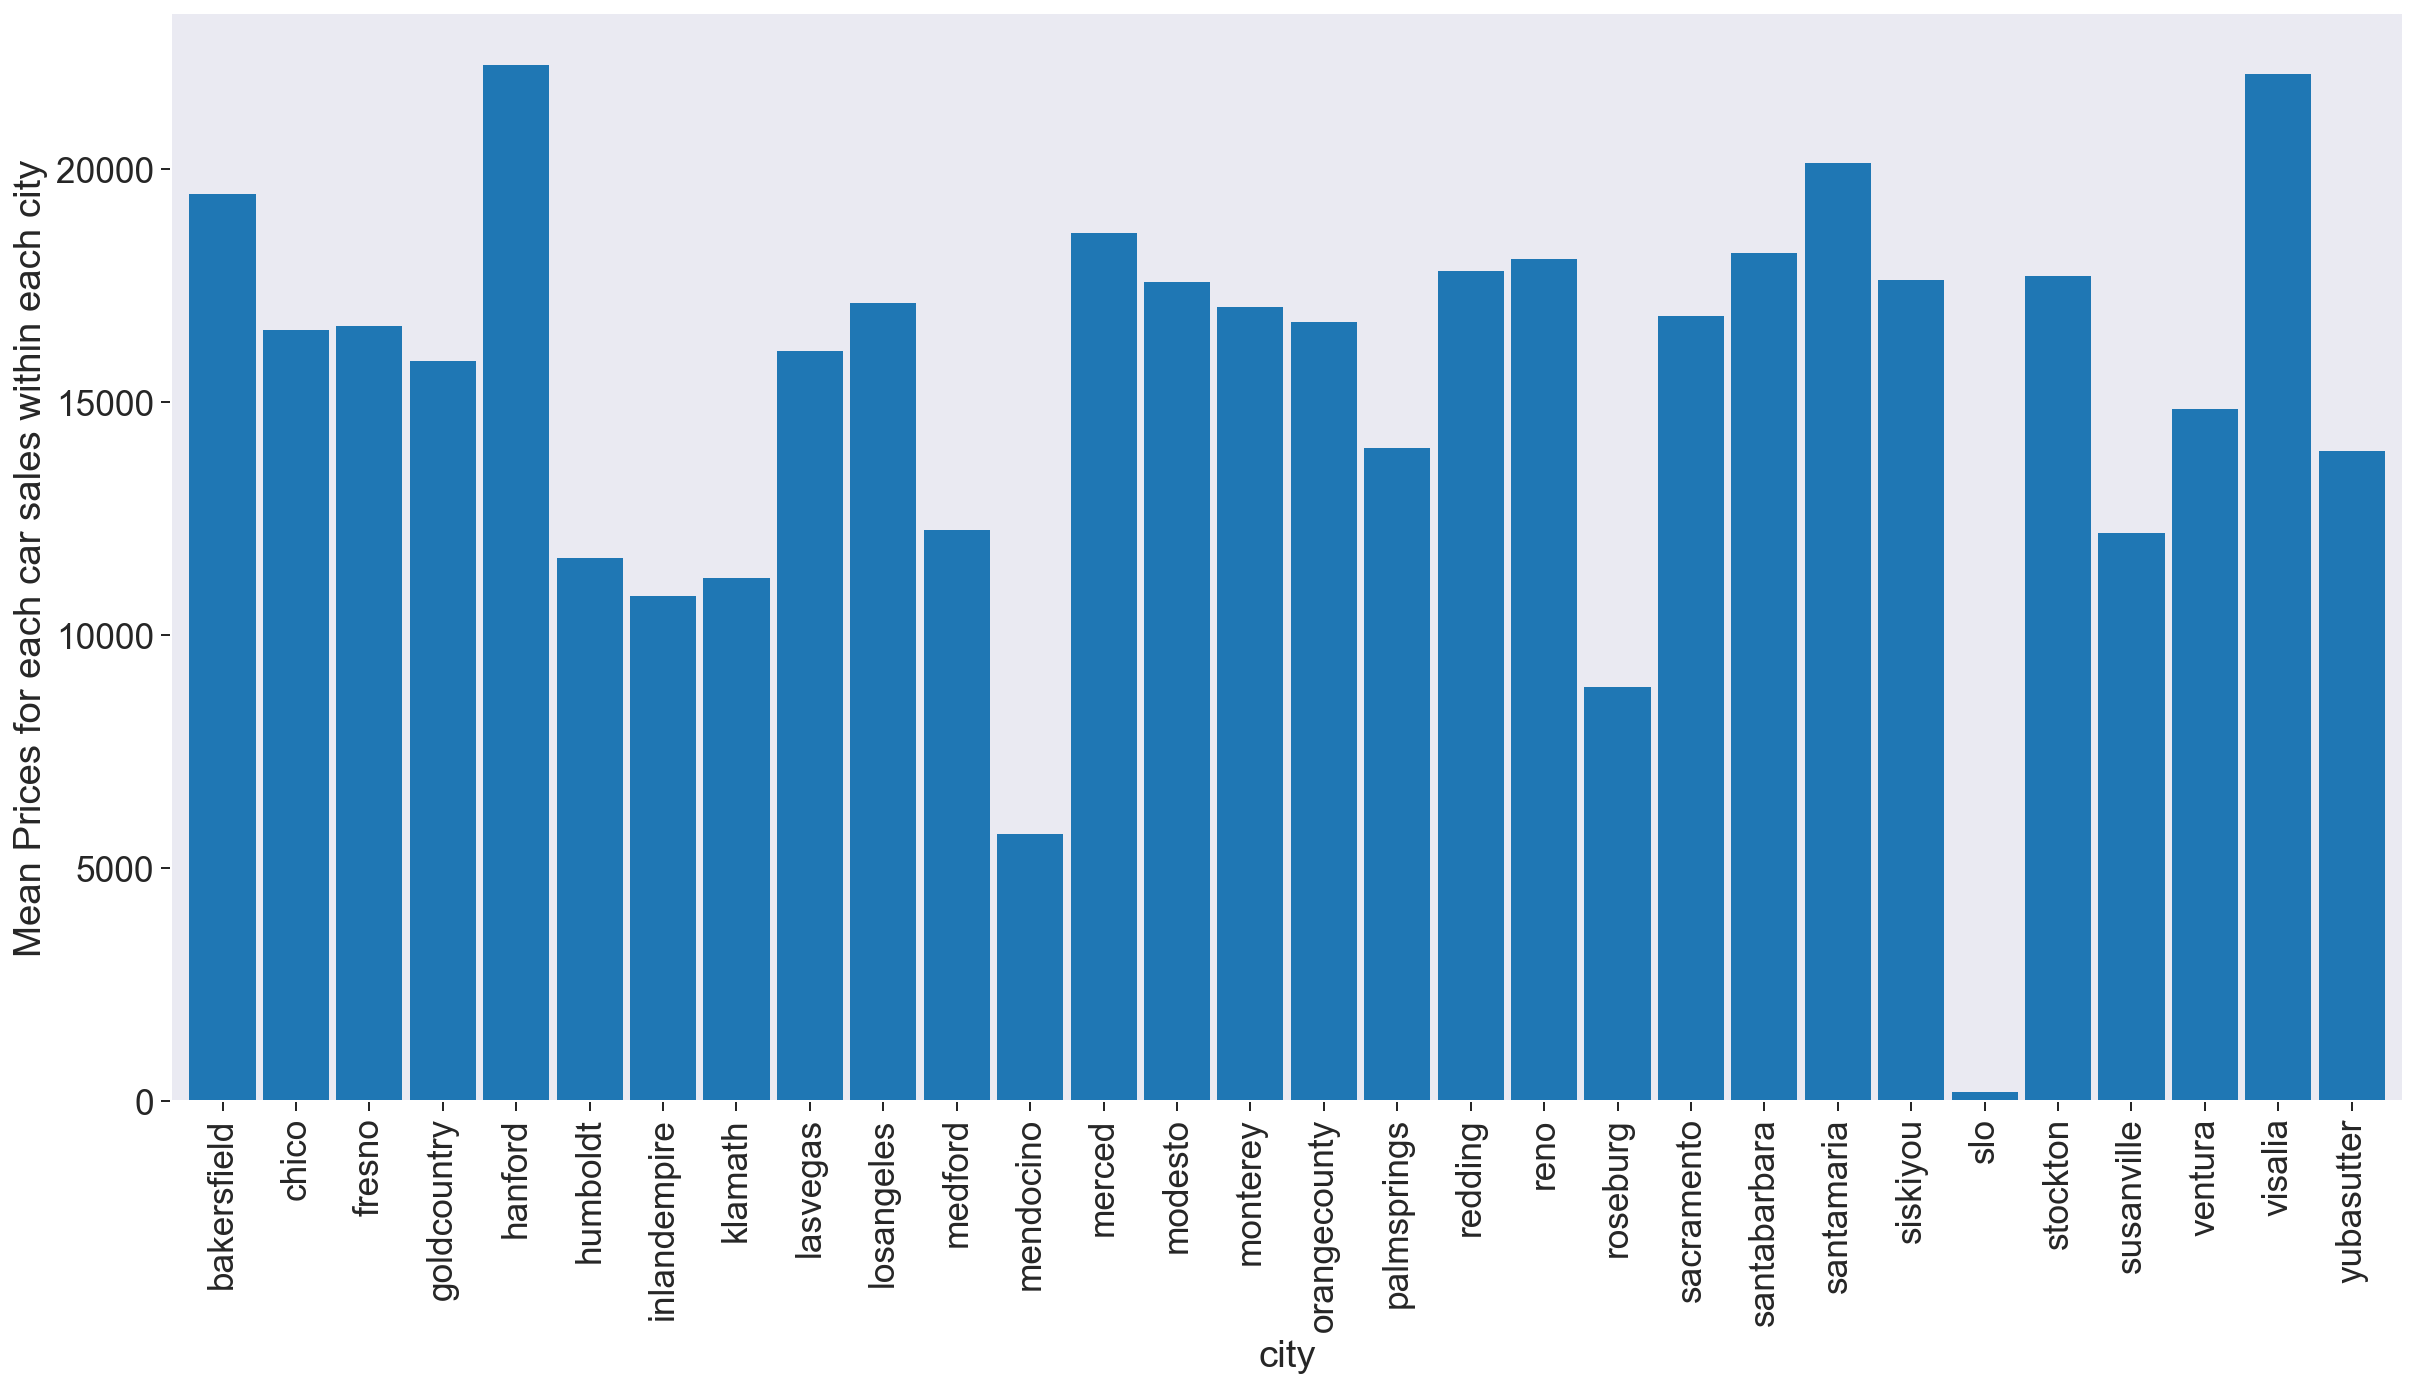

In [41]:
city_avg = cars.groupby('city')['price'].mean().round()
ax = city_avg.plot(kind='bar', figsize=(20,10), width=.9)
ax.set_ylabel('Mean Prices for each car sales within each city')
plt.savefig('sales_city.png', bbox_inches='tight')

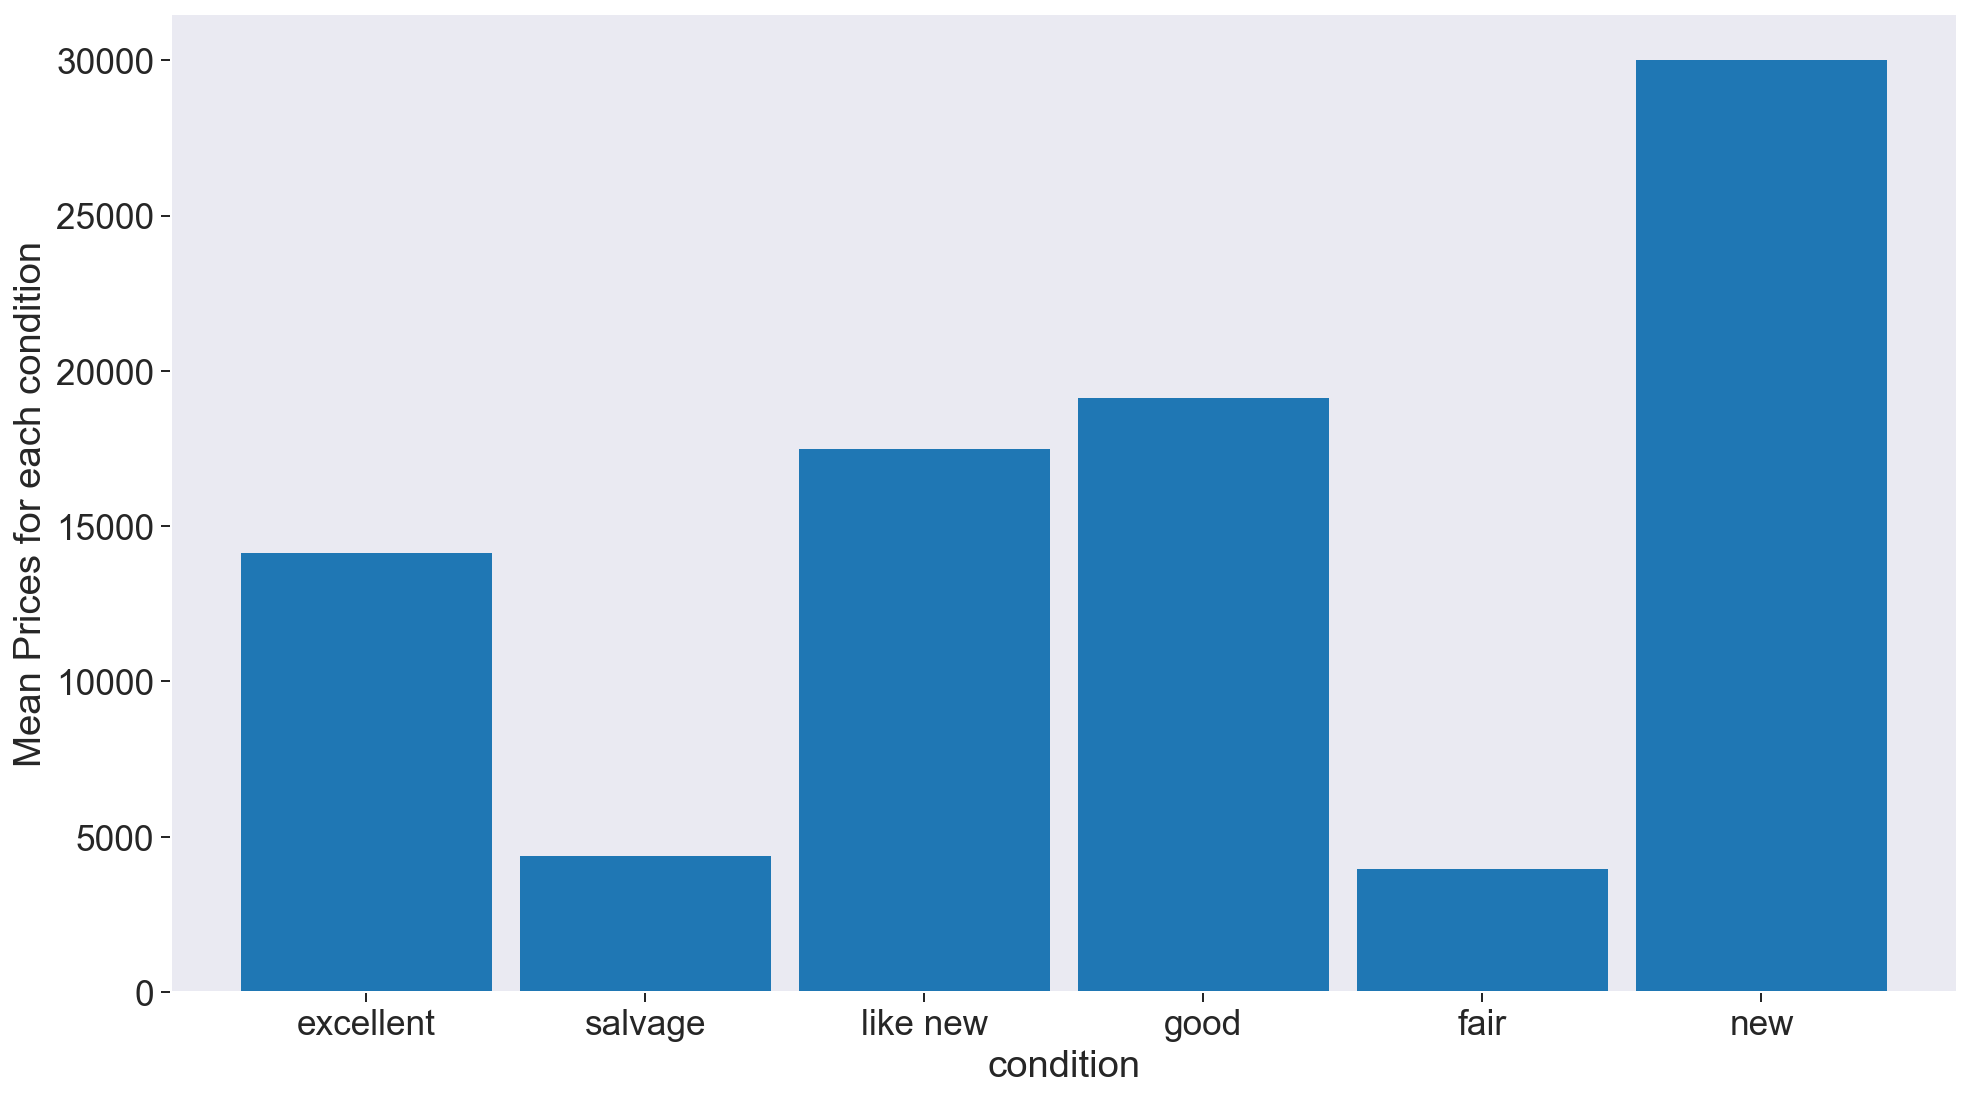

In [42]:
avg = cars.groupby('condition', sort=False)['price'].mean()
bx = avg.plot(kind='bar', rot=0, figsize=(16, 9), width=.9)
bx.set_ylabel('Mean Prices for each condition')
plt.savefig('price_condition.png', bbox_inches='tight')

In [43]:
price.max()

380000.0

In [44]:
price.min()

0.0

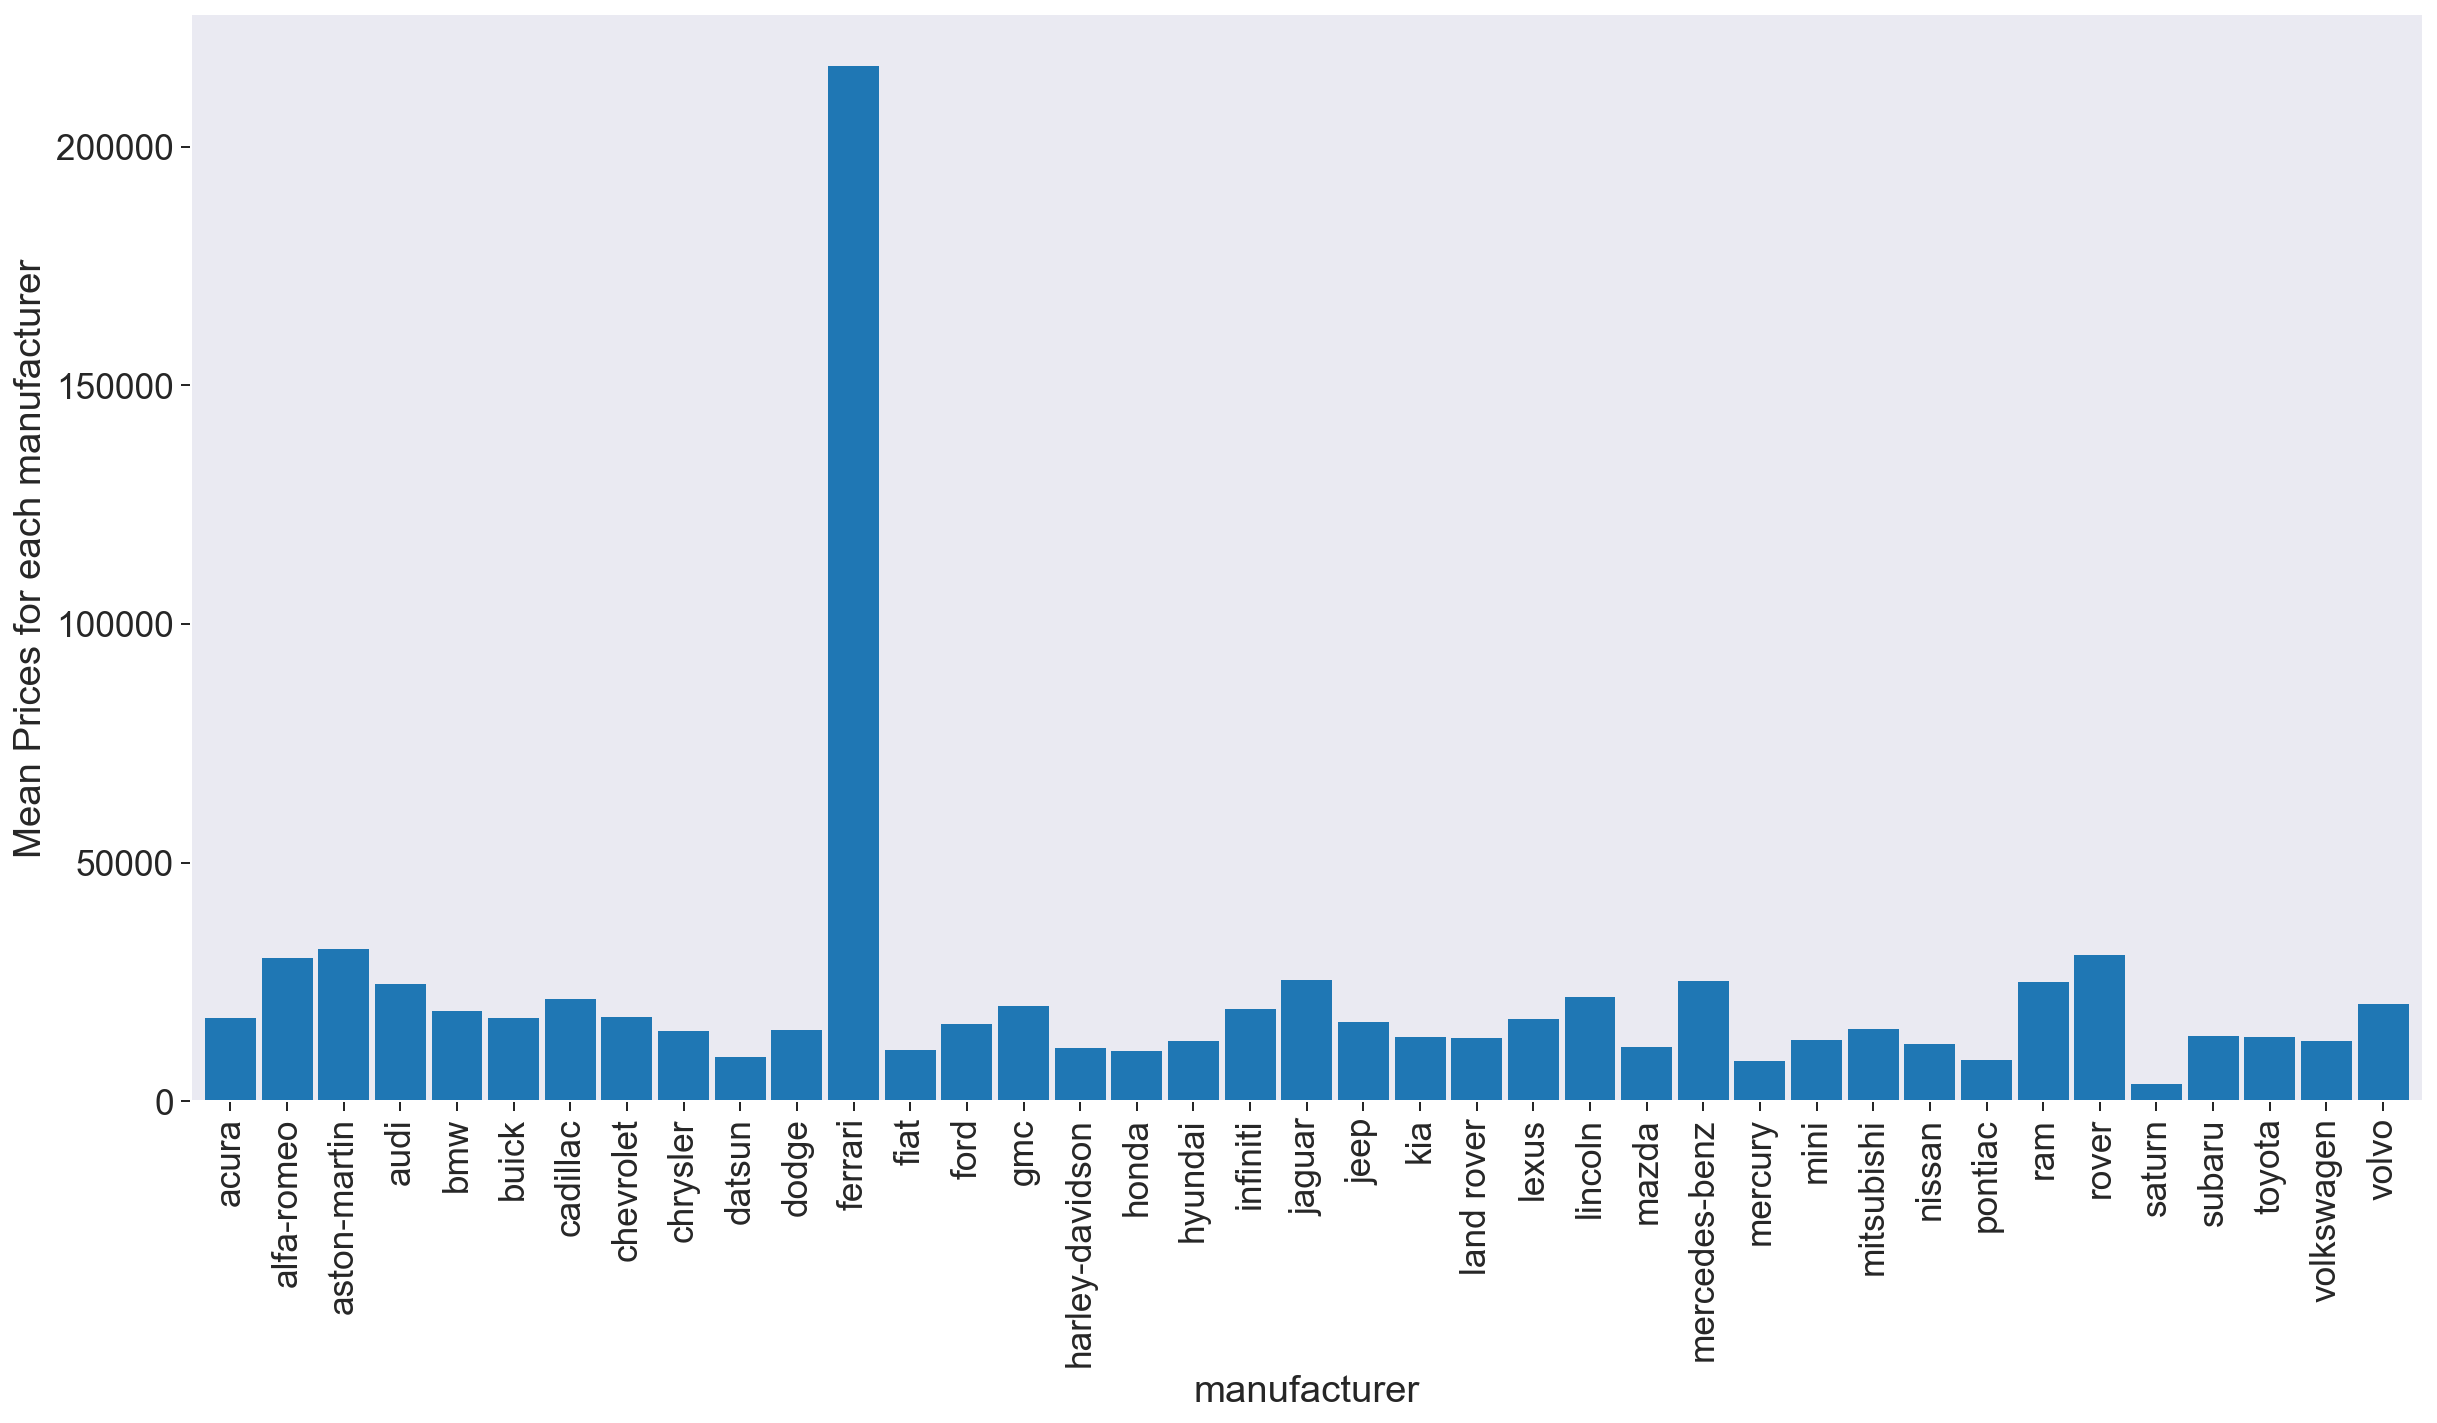

In [45]:
manufact = cars.groupby('manufacturer')['price'].mean().round()
ax = manufact.plot(kind='bar', rot=90, figsize=(20, 10), width=.9)
ax.set_ylabel('Mean Prices for each manufacturer')
plt.savefig('price_manufacturer.png', bbox_inches='tight')

This graph shows us the mean prices of cars for each manufacturer. Luxury vehicles such as ferrari, have a high average sales price of 200 000, followed by aston-martin with average 55 000. 

             price      year  odometer
price     1.000000  0.276383 -0.445867
year      0.276383  1.000000 -0.374719
odometer -0.445867 -0.374719  1.000000


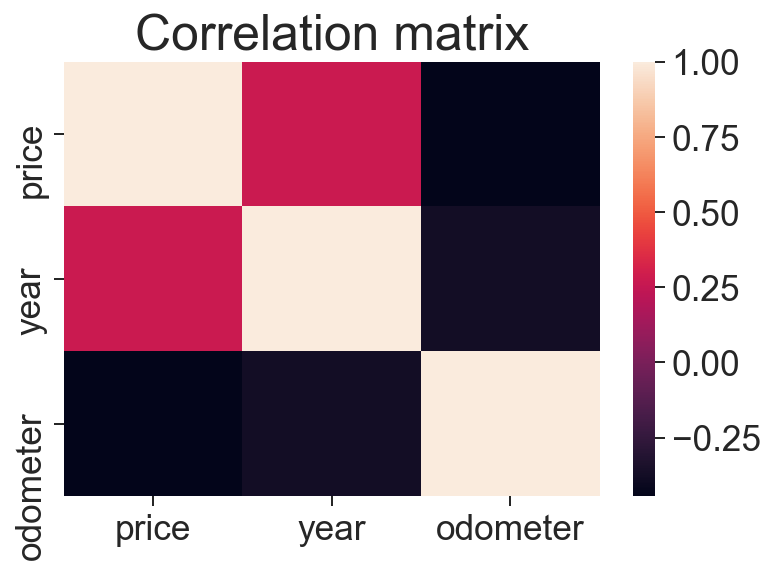

In [46]:
corr = cars.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot_kws={"size": 25})
plt.title('Correlation matrix', fontsize=25)
plt.savefig('corr_matrix.png', bbox_inches='tight')

All numeric variables' correlations are compared in this graph. Most variables aren't correlated at all, with the exception of moderate negative correlation between price and year, slight negative correlation between year and odometer, and slight positive correlation between year and price.

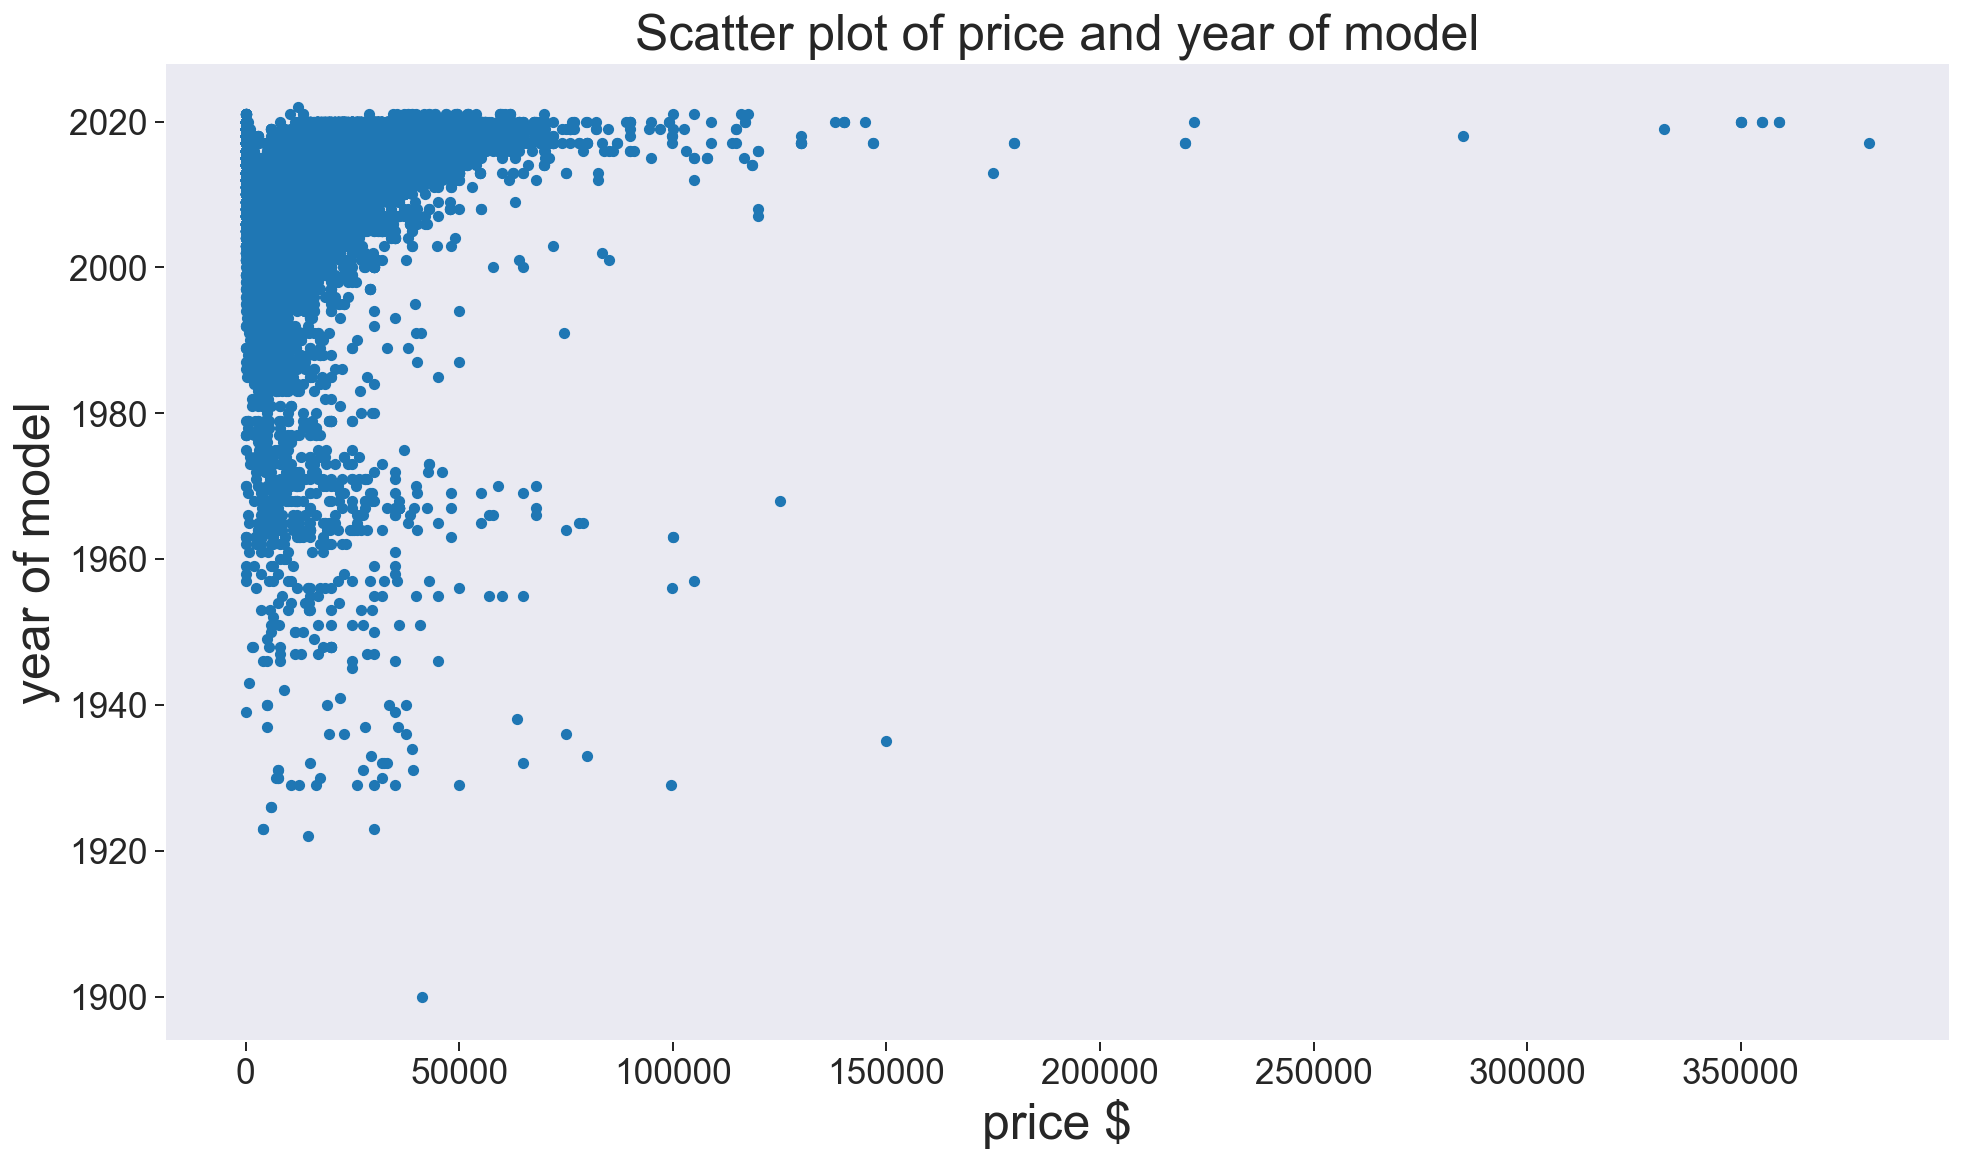

In [47]:
# visualize the distribution of cars price by their year model release

plt.figure(figsize=(16, 9))
# plot two values price per year_model
plt.scatter(cars.price, cars.year)
plt.xlabel("price $", fontsize=25)
plt.ylabel("year of model", fontsize=25)
plt.title("Scatter plot of price and year of model",fontsize=25)
plt.savefig('scatter.png', bbox_inches='tight')
plt.show()


As we can see from the plot above, the cars price increase respectivly by years, and more explicitly we can say that the more the car is recently released, the price augment, while in the other side the oldest cars still have a low price, and this is totally logical since whenever the cars become kind of old from the date of release, so their price start decrease.

# Data Modeling

## Linear Regression


In [48]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28634 entries, 24 to 52169
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         28634 non-null  float64
 1   city          28634 non-null  object 
 2   year          28634 non-null  float64
 3   manufacturer  28634 non-null  object 
 4   fuel          28634 non-null  object 
 5   odometer      28634 non-null  float64
 6   title_status  28634 non-null  object 
 7   transmission  28634 non-null  object 
 8   condition     28634 non-null  object 
dtypes: float64(3), object(6)
memory usage: 3.2+ MB


#### Dealing with Categorical Features

In [73]:
cars.columns

Index(['price', 'city', 'year', 'manufacturer', 'fuel', 'odometer',
       'title_status', 'transmission', 'condition'],
      dtype='object')

In [49]:
# Put together feature matrix and target vector
X = cars[['year', 'odometer', 'fuel', 'manufacturer', 'transmission', 'condition', 'title_status' ]]
y = cars['price']
X = pd.get_dummies(data=X, drop_first=True)

In [50]:
X.head()

,year,odometer,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,...,manufacturer_mitsubishi,manufacturer_nissan,manufacturer_pontiac,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo
24,2007.0,240000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48,1974.0,123.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,2006.0,194821.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,2006.0,194821.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
453,2008.0,135000.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Splitting

In [51]:
# Do train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2



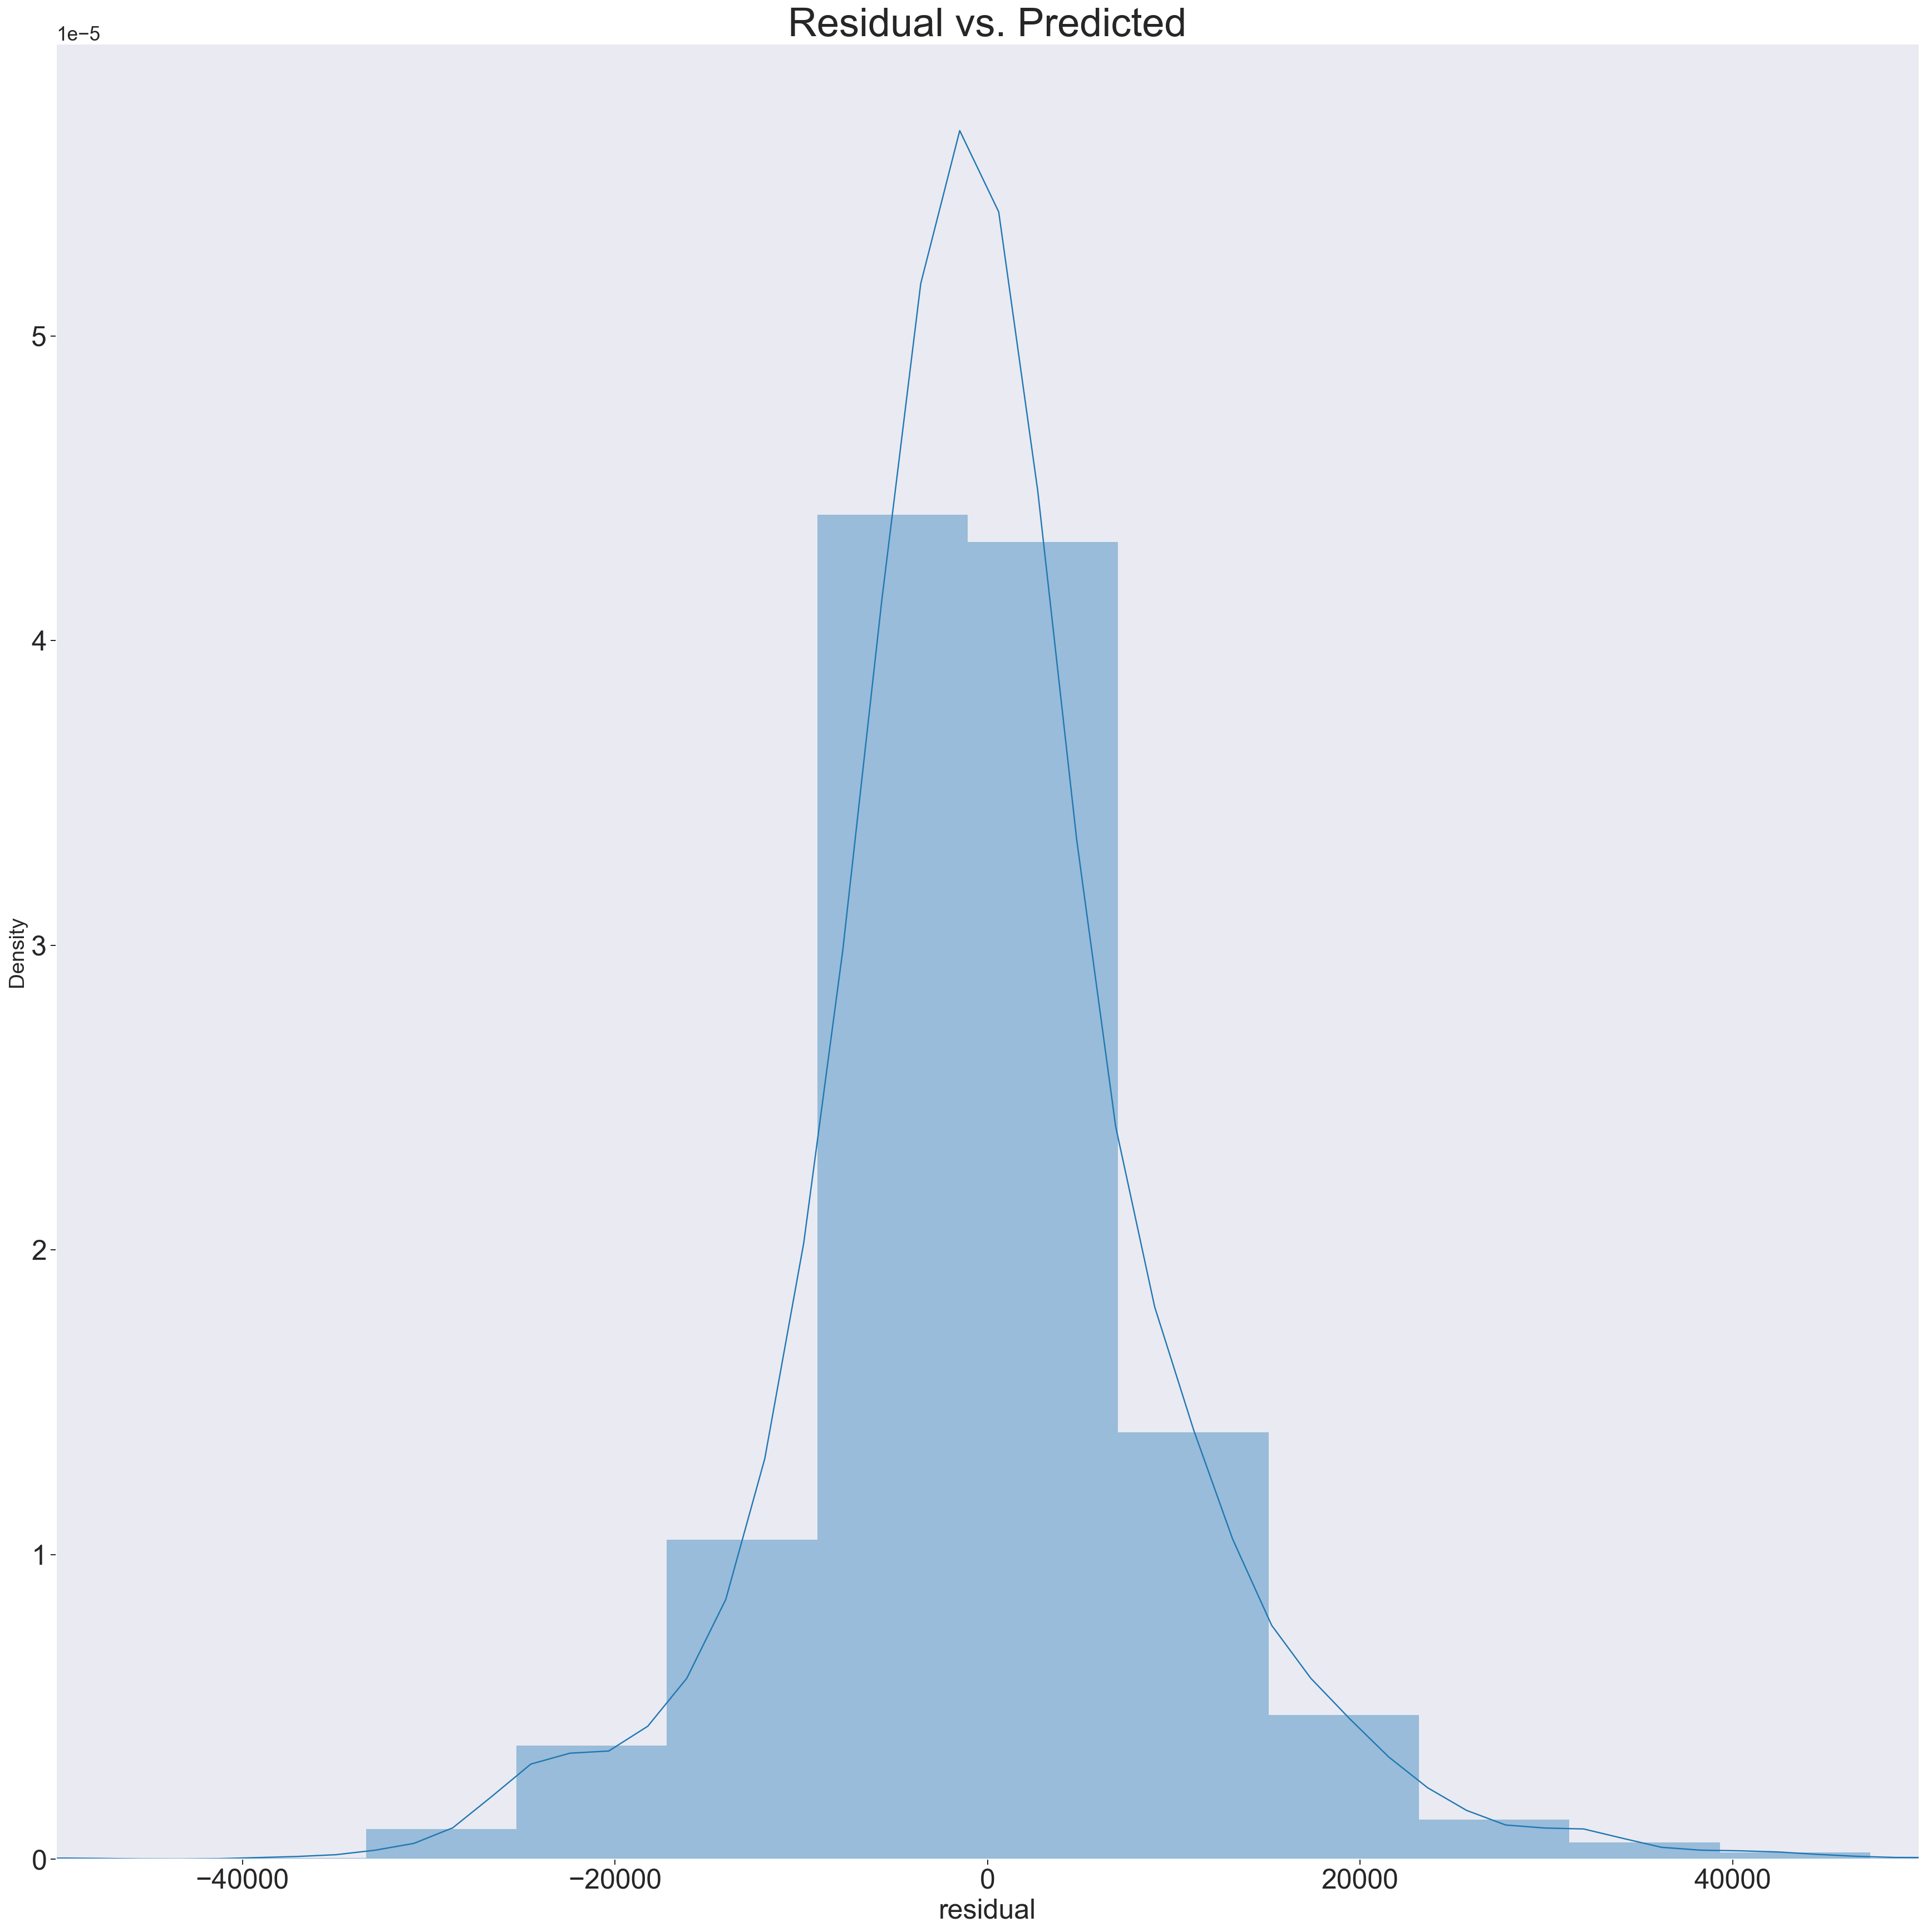

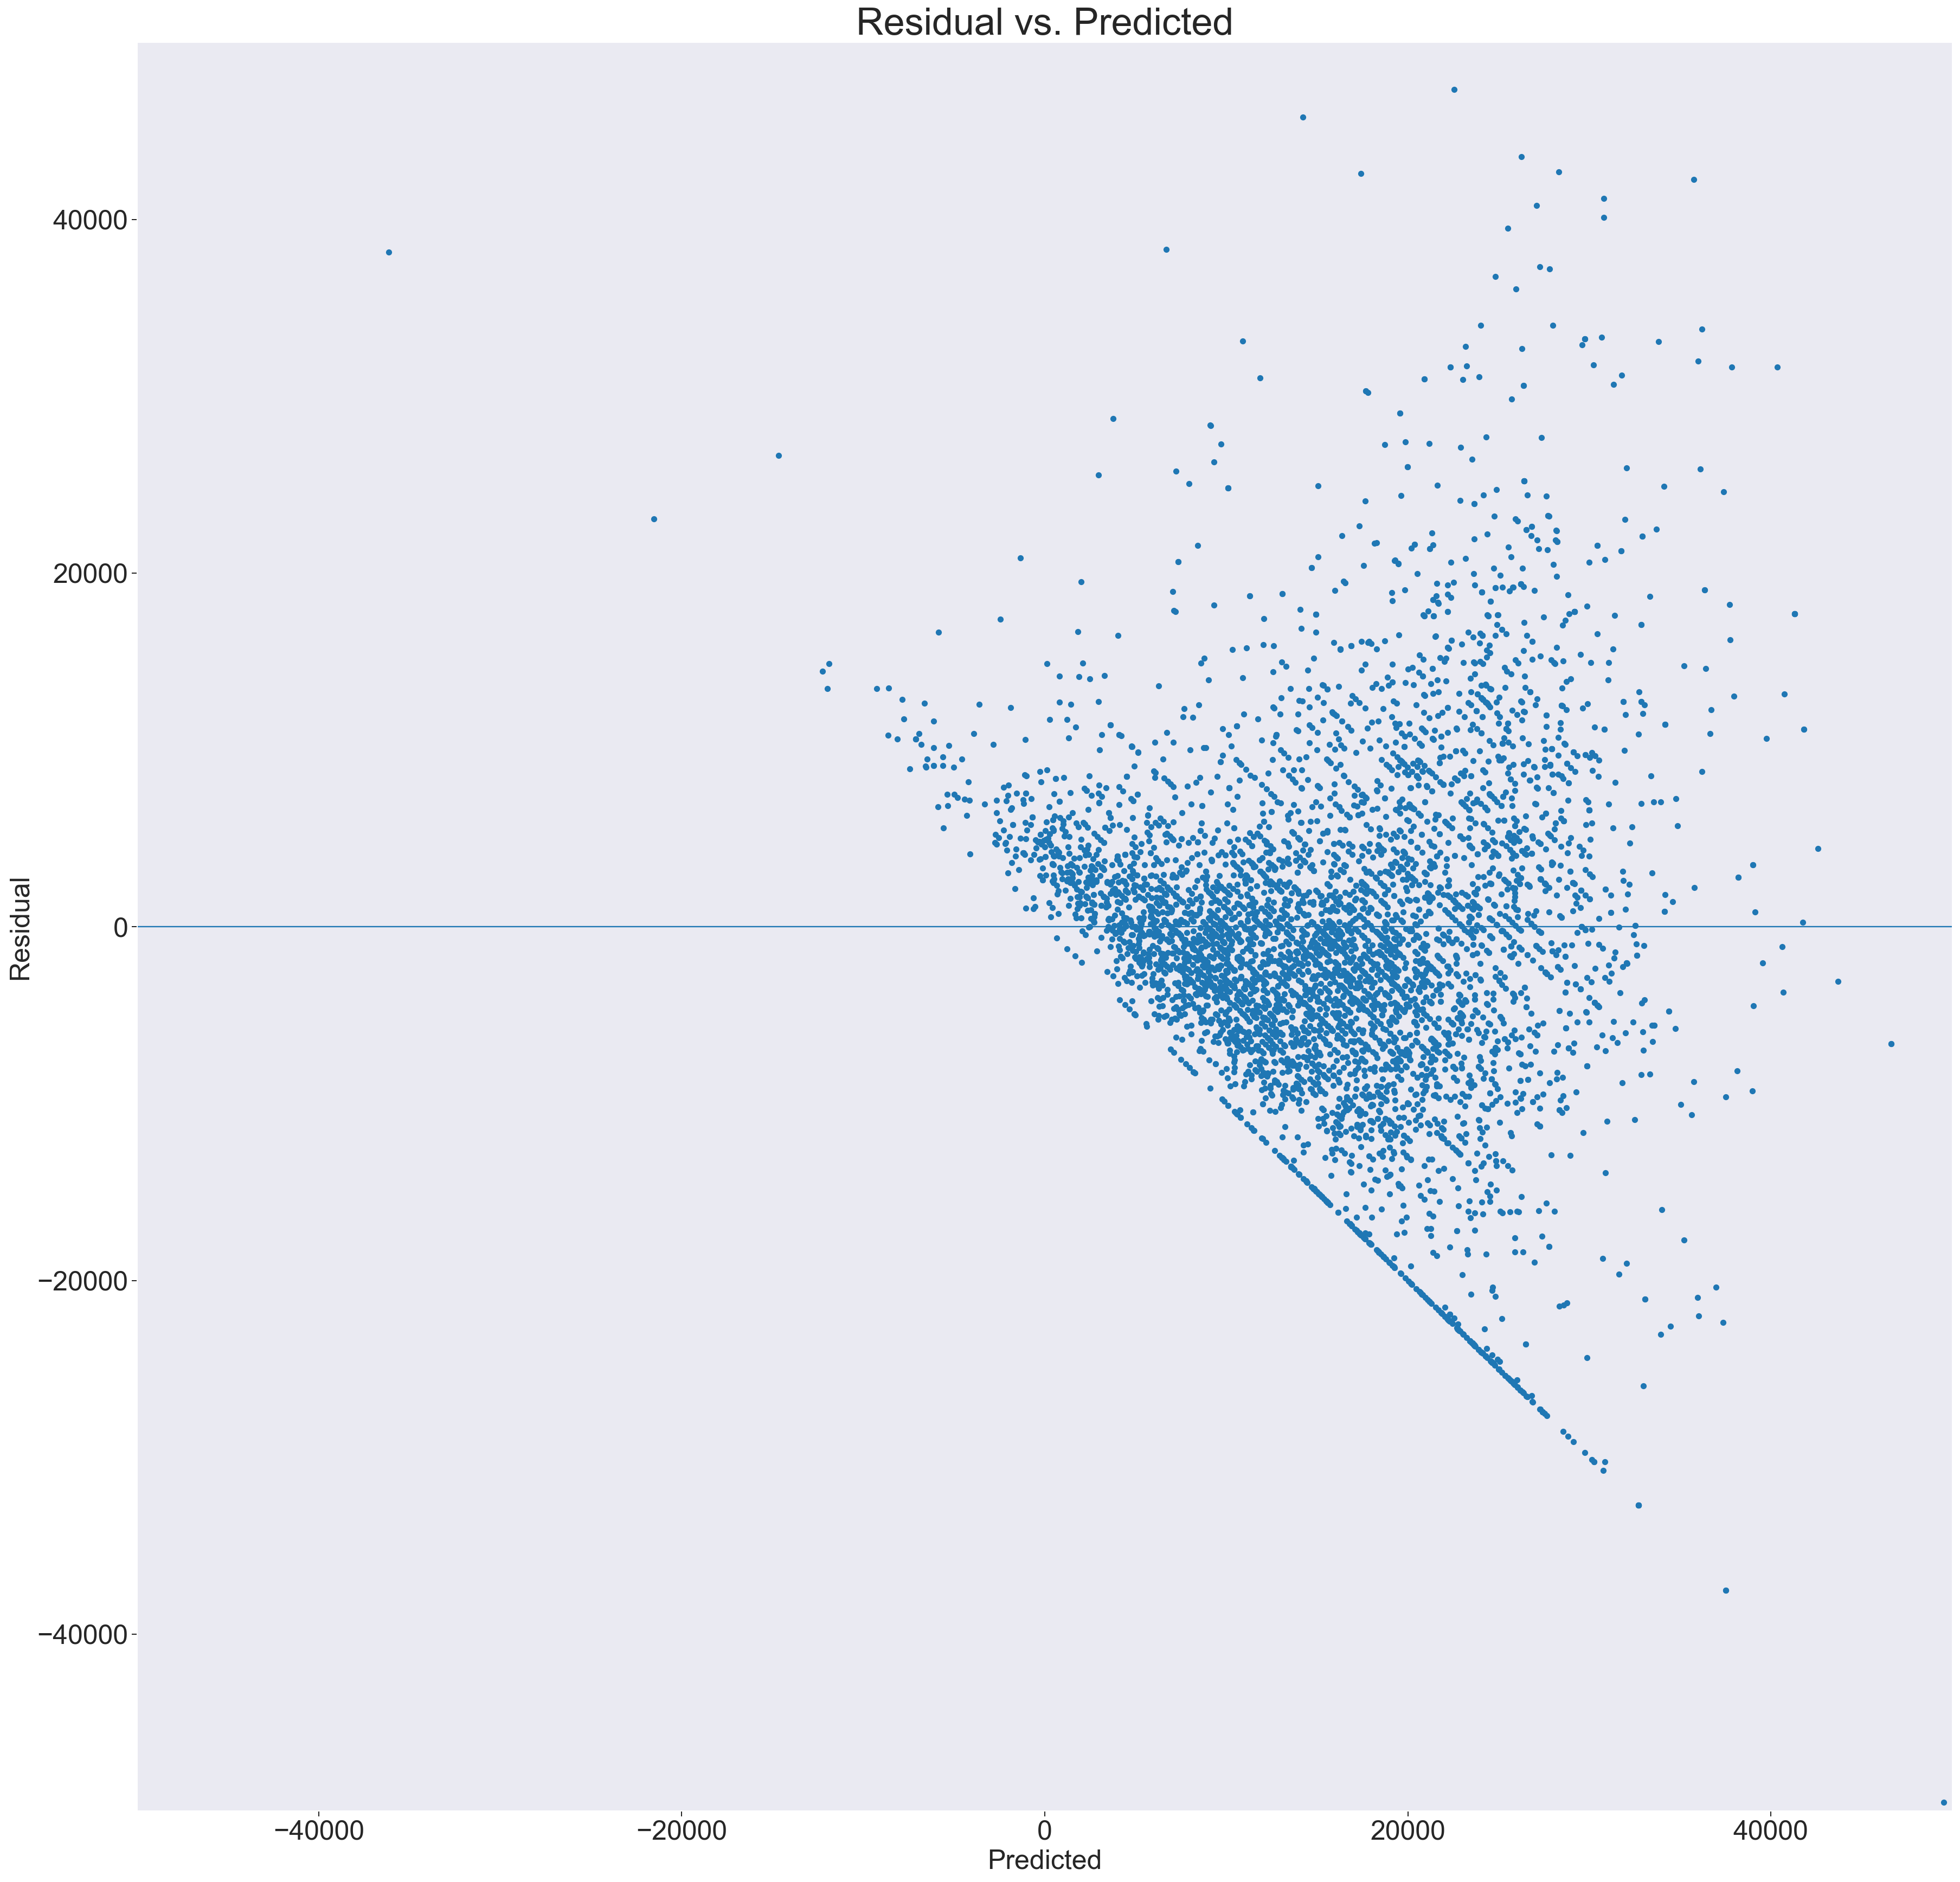

In [52]:
lr = LinearRegression()
# Fit using training set.
lr.fit(X_train, y_train)
# Create prediction
y_hat = lr.predict(X_test)
residual = y_test - y_hat

fig, ax = plt.subplots(figsize=(30,30))
sns.distplot(residual)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('residual', fontsize=25)
plt.xlim(-50000, 50000)
# plt.ylabel('', fontsize=25)
plt.axhline(y= 0)
plt.title('Residual vs. Predicted', fontsize=36)
plt.savefig('res_pred.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(30,30))
plt.scatter(y_hat, residual)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Predicted',fontsize=25)
plt.xlim(-50000, 50000)
plt.ylabel('Residual',fontsize=25)
plt.ylim(-50000,50000)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
plt.savefig('residual_pred.png', bbox_inches='tight')

plt.show()

In [53]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f'RMSE: {rmse}')

RMSE: 12038.113741889125


In [54]:
print('Variance score: %.2f' % r2_score(y_test, y_hat))

Variance score: 0.45


In [55]:
def train_and_valid(what_model, num_folds, X, y):
    fold_mae=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_mae.append(round(mean_absolute_error(valid_y, valid_pred), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold MAE:', fold_mae)
    avg_mae = round(np.mean(fold_mae),1)
    print('## Avg MAE:', avg_mae,'+-', round(np.std(fold_mae),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model, avg_mae

In [56]:
#Linear regression finds the coeficcients that minimize the residual sum of squares.
lr=LinearRegression(fit_intercept=True)
lr_clone, avg_mae=train_and_valid(what_model=lr, num_folds=10, X=X_train, y=y_train)

***Tune LinearRegression***
## Fold MAE: [7187.92, 7464.57, 7013.58, 7136.07, 7082.97, 7105.33, 6709.64, 6981.59, 7195.59, 7296.75]
## Avg MAE: 7117.4 +- 190.0
## Clone R^2: 0.42


In [57]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=20).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

NameError: name 'PermutationImportance' is not defined

## Descision Tree Regression

In [ ]:
dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, y_train)
y_hat = dtr.predict(X_test)
residual = y_test - y_hat

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.xlim(-50000, 50000)
plt.ylabel('Count',fontsize=25)
plt.savefig('res_count.png', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(y_hat, residual, color ='orange')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.xlim(-50000, 50000)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)
plt.savefig('res_pred_dt.png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('RMSE:')
print(rmse)

In [58]:
print('Variance score: %.2f' % r2_score(y_test, y_hat))

Variance score: 0.45


## Random Forest

In [59]:
rf = RandomForestRegressor()

In [60]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [61]:
y_hat = rf.predict(X_test)

In [62]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print('RMSE:')
print(rmse)
print('Variance score: %.2f' % r2_score(y_test, y_hat))

RMSE:
9201.625702317466
Variance score: 0.68


In [63]:
feature_importances = np.argsort(rf.feature_importances_)

In [64]:
cars.columns

Index(['price', 'city', 'year', 'manufacturer', 'fuel', 'odometer',
       'title_status', 'transmission', 'condition'],
      dtype='object')

In [65]:
print("\ntop five:", list(X_train.columns[feature_importances[-1:-6:-1]]))


top five: ['odometer', 'year', 'manufacturer_ferrari', 'fuel_gas', 'manufacturer_mercedes-benz']



Feature ranking:
1. odometer (0.512144)
2. year (0.181832)
3. fuel_gas (0.030096)
4. fuel_other (0.015165)
5. fuel_hybrid (0.009008)
6. manufacturer_audi (0.007749)
7. manufacturer_bmw (0.007349)
8. fuel_electric (0.002124)
9. manufacturer_aston-martin (0.000521)
10. manufacturer_alfa-romeo (0.000374)


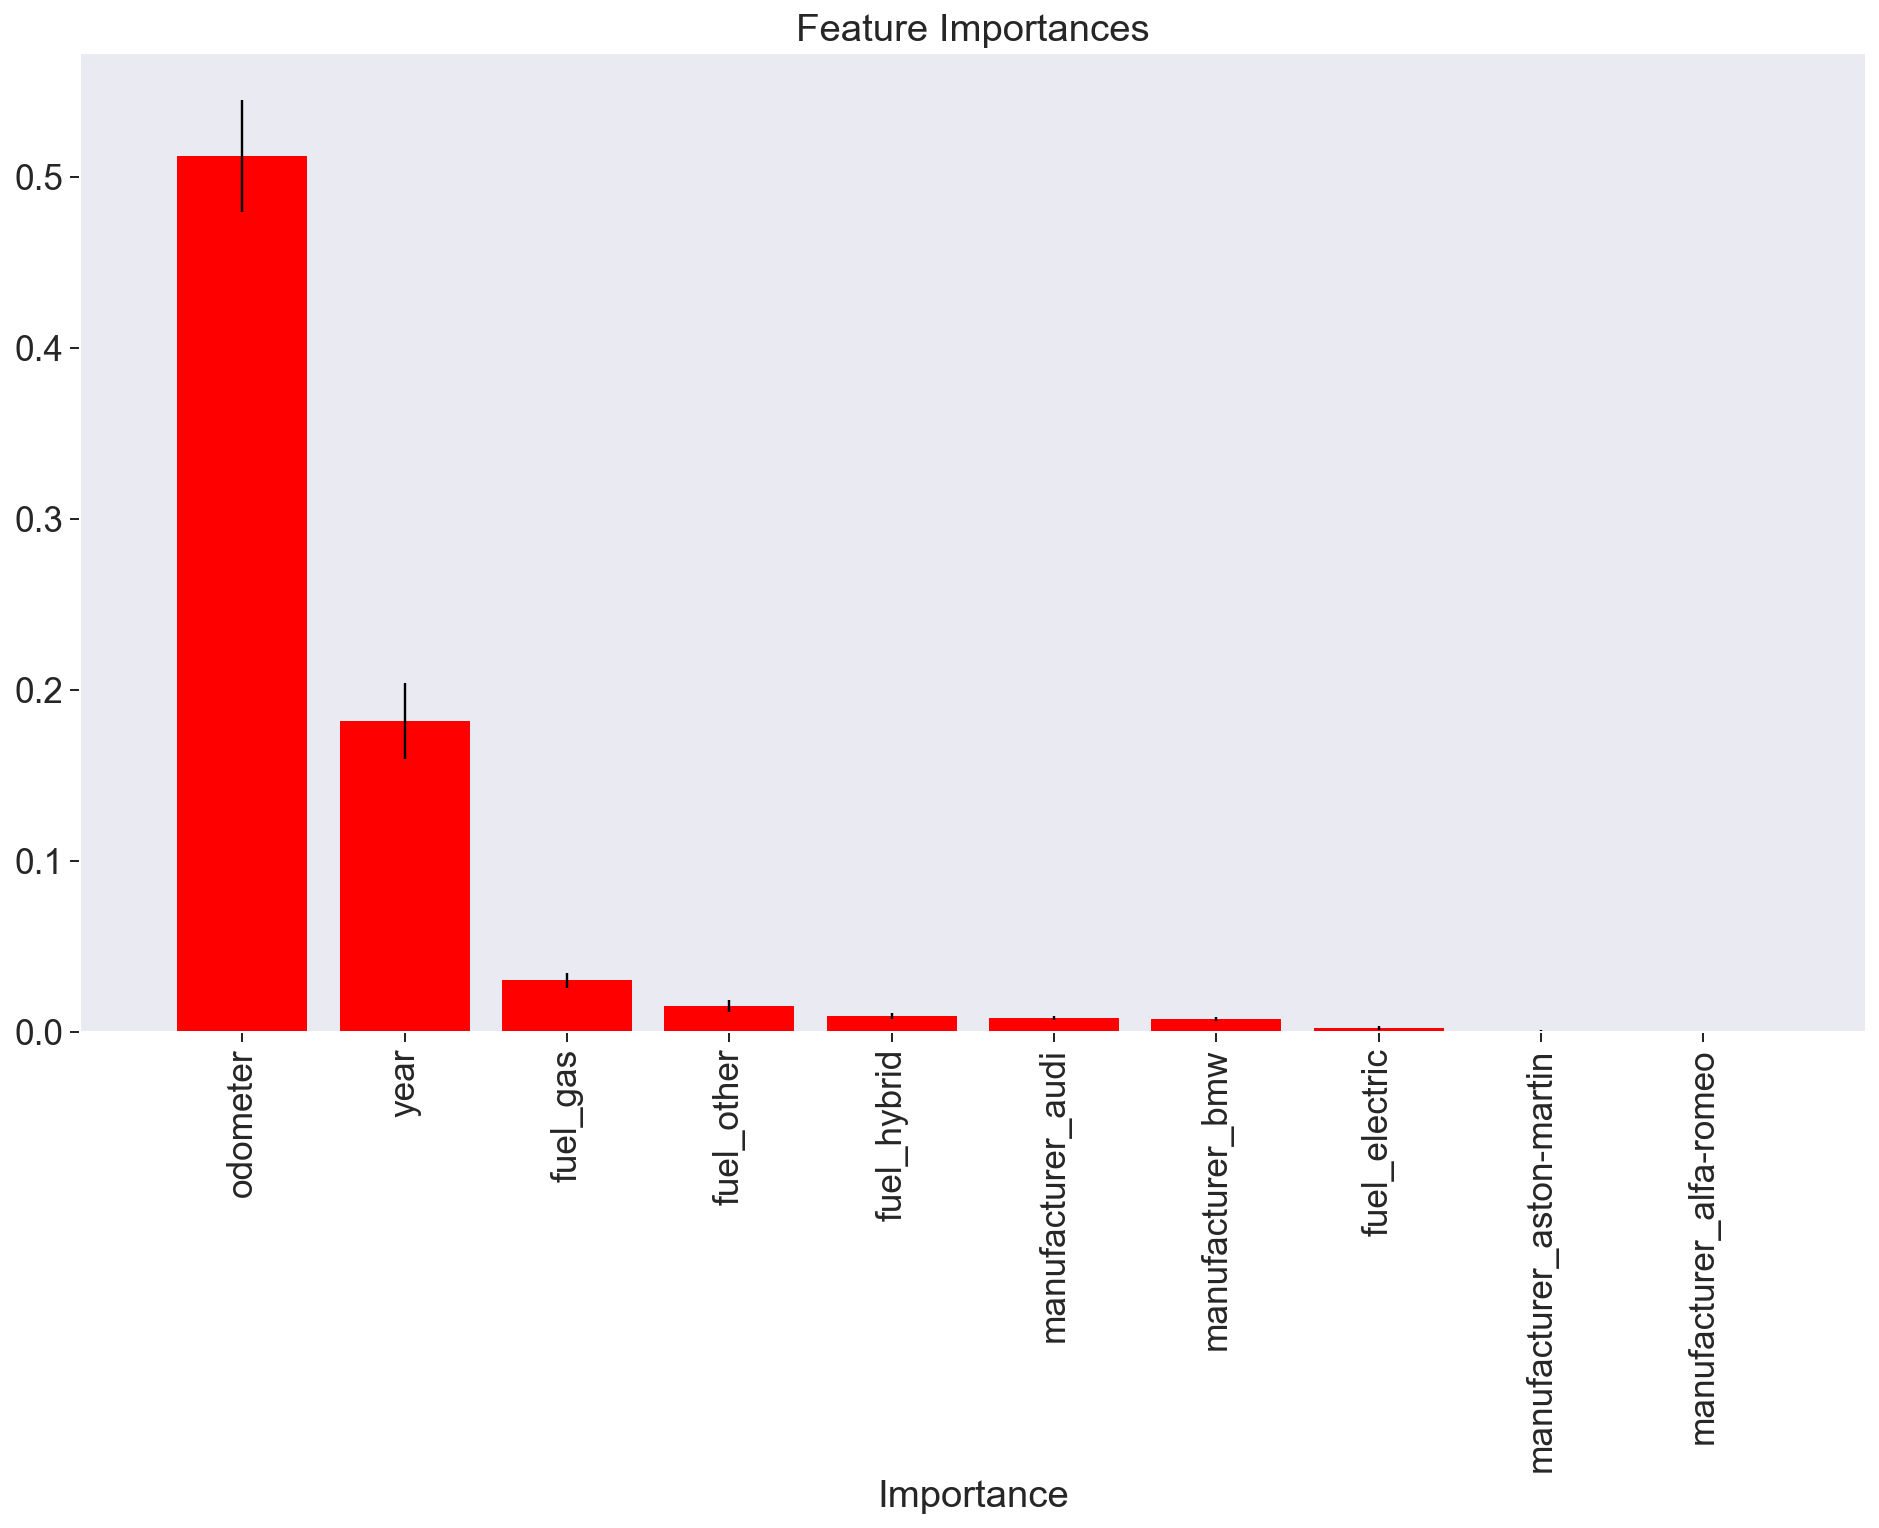

In [66]:
# Calculate the standard deviation for feature importances across all trees

n = 10 # top 10 features

#importances = forest_fit.feature_importances_[:n]
importances = rf.feature_importances_[:n]
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(X_train.columns[indices])

# Print the feature ranking
print("\nFeature ranking:")

for f in range(n):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
fig, ax = plt.subplots(figsize=(16, 9))

ax.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(features, rotation = 90)
ax.set_xlim([-1, 10])
ax.set_xlabel("Importance")
ax.set_title("Feature Importances")
plt.savefig('feature_importance.png', bbox_inches='tight')

Text(0.5, 1.0, 'Accuracy vs. Num Trees')

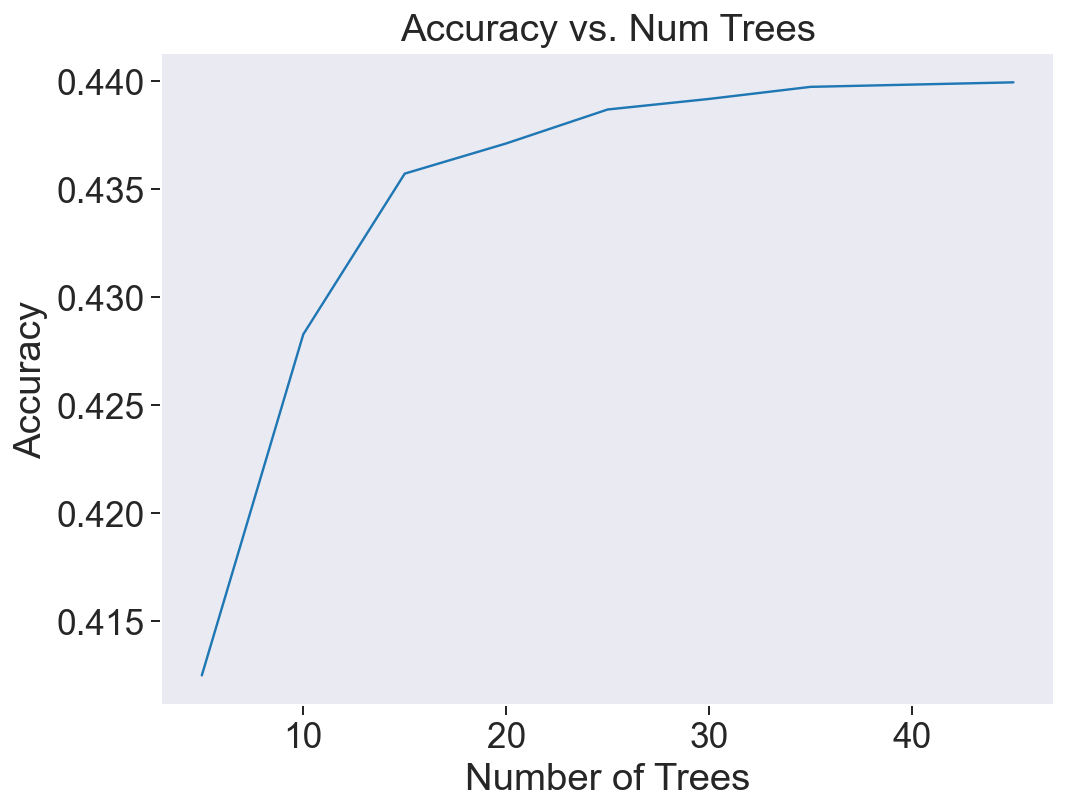

In [67]:
# Try modifying the number of trees
num_trees = range(5, 50, 5)
accuracies = []
for n in num_trees:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs. Num Trees')

In [68]:
# Try modifying the max features parameter
num_features = range(1, len(X.columns) + 1)
accuracies = []
for n in num_features:
    tot = 0
    for i in range(5):
        rf = RandomForestClassifier(max_features=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(num_features, accuracies)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs. Num Features')
## Levels off around 5-6

KeyboardInterrupt: 

In [ ]:
# 16. Run all the other classifiers that we have learned so far in class
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict), \
           recall_score(y_test, y_predict)

print("\n16. Model, Accuracy, Precision, Recall")
print("    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=25, max_features=5))
print("    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test))
print("    Decision Tree:", get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test))
print("    Naive Bayes:", get_scores(MultinomialNB, X_train, X_test, y_train, y_test))
# Results may not match new/previous runs. 
## MODEL               ACCURACY PRECISION    RECALL
## Random Forest         0.9508    0.8817    0.7321
## Logistic Regression   0.8741    0.6129    0.1696
## Decision Tree         0.9209    0.6949    0.7321

In [ ]:
print("17. Use the included `plot_roc` function to visualize the roc curve of each model")
plot_roc(X, y, RandomForestClassifier, 'Random_Forest', n_estimators=25, max_features=5)
plot_roc(X, y, LogisticRegression, 'Logistic_Regression')
plot_roc(X, y, DecisionTreeClassifier, 'Decision_Tree')
#plot_roc(X, y, MultinomialNB, 'Naive_Bayes')


## Gradient Boosting

In [ ]:
r_sq = []
deep = []
mean_scores = []

#loos:
for n in range(3, 11):
    gbr = GradientBoostingRegressor(loss='ls', max_depth=n)
    gbr.fit(X_train, y_train)
    deep.append(n)
    r_sq.append(gbr.score(X, y))
    mean_scores.append(cross_val_score(gbr, X, y, cv=12).mean())

In [ ]:
gbr_df = pd.DataFrame()

gbr_df['mean_scores'] = mean_scores
gbr_df['depth'] = deep
gbr_df['r_sq'] = r_sq

fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(data=gbr_df, x='depth', y='mean_scores')
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(data=gbr_df, x='depth', y='r_sq')
plt.show()

In [ ]:
gbr = GradientBoostingRegressor(loss='ls', max_depth=6)
gbr.fit(X_train, y_train)
y_had = gbr.predict(X_test)
residual = y_test - y_had

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.xlim(-40000,40000)
plt.ylabel('Count',fontsize=25)

plt.show()



In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
plt.scatter(y_hat, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.xlim(-40000, 40000)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
scores = cross_val_score(gbr, X_test, y_test, cv=12)

print('\nCross Validation Scores:')
print(scores)
print('\nMean Score:')
print(scores.mean())
print('\nRMSE:')
print(rmse)

In [ ]:
print('Variance score: %.2f' % r2_score(y_test, y_hat))

## Prediction vs Real price histogram

In [ ]:
scaler = StandardScaler()
A = scaler.fit_transform(pd.DataFrame(y_test))
B = scaler.fit_transform(pd.DataFrame(y_hat))

In [ ]:
plt.rcParams['figure.figsize'] = 16,9
plt.figure()
plt.plot(A[-100:], label="Real")
plt.plot(B[-100:], label="Predicted")
plt.legend()
plt.title("Price: real vs predicted")
plt.ylabel("price")
plt.xticks(())
plt.show()

## Model Evaluation

In [ ]:
def evaluate_reg_models(self, model_lst, X_train, y_train, X_test, y_test):
        """ Method to evaluate different regression models with vectorized text

        Args:
            model_lst: List of models to test
            X_train: X_train data to use for evaluation
            y_train: y_train data to use for evaluation
            X_test: X_test data to use for evaluation
            y_test: y_test data to use for evaluation

        Returns:
            rmse_dict: Dictionary with the models and their RMSE results

        """
        rmse_dict = {}
        r2_dict = {}

        for model in model_lst:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))
            print(f"The RMSE of model {type(model).__name__} is {rmse :.2f}")
            print("\n")

            rmse_dict[type(model).__name__] = rmse

        #Plot the RMSE results
        plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
        plt.barh(*zip(*rmse_dict.items()))
        plt.xlabel('RMSE', size = 25)
        plt.ylabel('Model', size = 25)
        plt.title('Regression Model Comparison', size = 25)
        plt.xticks(size = 20)
        plt.yticks(size = 20)
        plt.grid()
        plt.show()

        return rmse_dict

In [ ]:
# now, create a list with the regression objects 
reg_models= [dt, rf, gb]
#Run and evaluate the results
rmse_dict = lr.evaluate_reg_models(reg_models, X_train, y_train, X_test, y_test) 

## Predict an observation never seen before

In [71]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=23)

In [72]:
y_hat = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_hat))
print('RMSE:')
print(rmse)

RMSE:
10348.452653056618
Variance score: -0.74


In [83]:
len(y_test)

5728

In [84]:
base = np.full(5728,avg_price.mean())


In [86]:
y_hat = base
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f'RMSE:{rmse}')

RMSE:16253.585531858726
